# Récuperation et traitement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL.ImageOps import autocontrast, equalize
from PIL import ImageFilter
from skimage.restoration import denoise_nl_means, estimate_sigma
import os
import numpy as np
import pandas as pd
import time
import seaborn as sn
from pickle import Pickler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, f1_score

import tensorflow as tf
from keras.models import Sequential, load_model, save_model
#from keras.optimizers import SGD, Adam, RMSprop
from keras import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet169
from keras.applications.nasnet import NASNetLarge
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
# On parcour les 5 premiers dossiers, les noms des dossiers nous donnes les labels.
# Pour chacun des dossiers on recupère les images que l'on 
# traite : Filtre médian / Luminosité / constraste 

picture = []
label = []

# parcours sur le drive
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = Image.open(img)
        im = im.filter(ImageFilter.MedianFilter(size=3))
        im = autocontrast(im)
        im = equalize(im)
        im = im.resize((224, 224))
        im = np.array(im)/255
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

# Split des données

In [ ]:
# Split
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# On OneHotEncode les labels
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

# Définition du CNN from scratch
### On crée un réseau plus simple que le VGG16 pour essayé de limiter le nombre de paramètre a apprendre. Après plusieurs architecture testé on conserve les structures suivantes.

### with dropout and batchnormalization

In [ ]:
def model_db(activation='relu', optimizer='sgd', dropout_rate=0.2):
    
    my_VGG16 = Sequential()
    my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(Flatten())
    my_VGG16.add(Dense(1024))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(512))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(256))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(128))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(64))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(5, activation='softmax'))
    my_VGG16.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
    return my_VGG16

### Only BatchNormalization

In [ ]:
def model_b(activation='relu', optimizer='sgd'):
    
    my_VGG16 = Sequential()
    my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(Flatten())
    my_VGG16.add(Dense(1024))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dense(512))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dense(256))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dense(128))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dense(64))
    my_VGG16.add(Activation(activation))
    my_VGG16.add(BatchNormalization())
    my_VGG16.add(Dense(5, activation='softmax'))
    my_VGG16.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
    return my_VGG16

### only with dropout

In [ ]:
def model_d(activation='relu', optimizer='sgd', dropout_rate=0.2):
    
    my_VGG16 = Sequential()
    my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(Flatten())
    my_VGG16.add(Dense(1024, activation=activation))
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(512, activation=activation))
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(256, activation=activation))
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(128, activation=activation))
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(64, activation=activation))
    my_VGG16.add(Dropout(dropout_rate))
    my_VGG16.add(Dense(5, activation='softmax'))
    my_VGG16.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
    return my_VGG16

### Without dropout

In [ ]:
def model(activation='relu', optimizer='sgd', dropout_rate=0.2):
    
    my_VGG16 = Sequential()
    my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
    my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    my_VGG16.add(Flatten())
    my_VGG16.add(Dense(1024, activation=activation))
    my_VGG16.add(Dense(512, activation=activation))
    my_VGG16.add(Dense(256, activation=activation))
    my_VGG16.add(Dense(128, activation=activation))
    my_VGG16.add(Dense(64, activation=activation))
    my_VGG16.add(Dense(5, activation='softmax'))
    my_VGG16.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
    return my_VGG16

# Grille de recherche des hyperparamètres
### Pour chacun des modèles on ne effectue une grille des recherche.

In [ ]:
tuned_parameters_a = {'activation': ['relu', 'tanh'],
                    'optimizer': ['sgd', 'adam'], 
                    'nb_epoch': [100],
                    'batch_size': [5, 10, 30],
                    'dropout_rate': [0.2, 0.3]}
tuned_parameters_b = {'activation': ['relu', 'tanh'],
                    'optimizer': ['sgd', 'adam'], 
                    'nb_epoch': [100],
                    'batch_size': [5, 10, 30]}

In [ ]:
# List des modèles
modelList = {'norm':model, 'drop':model_d, 'dropBn':model_db}
topModel = []

# Cross Validation
Ti = time.time()
cv = KFold(n_splits=2)  # Pour limiter les temps de calcul

# On utilise le wrapper scikit learn par keras
# de manière a utiliser GrisSerachCV
modelk = KerasClassifier(build_fn=model)

# Grille de recherche, retourne le meilleur classifieur

for i, m in modelList.items():
  if i == 'norm':
    tuned_parameters = tuned_parameters_b
  else:
    tuned_parameters = tuned_parameters_a
  modelk = KerasClassifier(build_fn=m)
  clsBest = GridSearchCV(estimator=modelk, param_grid=tuned_parameters, cv=cv)
  clsBest.fit(X_train, y_train)
  topModel.append(clsBest)

Tf = time.time()
print(Tf - Ti)

153/153 [==============================] - 7s 24ms/step - loss: 2.2404 - accuracy: 0.1677
700.8797380924225


# Affichage des meilleurs Classifieurs

In [ ]:
# With Dropout
pd.DataFrame(topModel[1].cv_results_).sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_dropout_rate,param_nb_epoch,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
18,3.780026,0.850496,1.143414,0.033227,tanh,10,0.3,100,sgd,"{'activation': 'tanh', 'batch_size': 10, 'drop...",0.304462,0.247368,0.275915,0.028547,1
20,2.765290,0.133812,0.976151,0.011150,tanh,30,0.2,100,sgd,"{'activation': 'tanh', 'batch_size': 30, 'drop...",0.296588,0.247368,0.271978,0.024610,2
12,3.945147,0.200233,1.238963,0.041679,tanh,5,0.2,100,sgd,"{'activation': 'tanh', 'batch_size': 5, 'dropo...",0.286089,0.255263,0.270676,0.015413,3
11,2.931681,0.084768,1.065948,0.122772,relu,30,0.3,100,adam,"{'activation': 'relu', 'batch_size': 30, 'drop...",0.286089,0.247368,0.266729,0.019360,4
15,4.572777,0.163906,1.279911,0.046685,tanh,5,0.3,100,adam,"{'activation': 'tanh', 'batch_size': 5, 'dropo...",0.286089,0.247368,0.266729,0.019360,4


In [ ]:
# Without Dropout
pd.DataFrame(topModel[0].cv_results_).sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_nb_epoch,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
8,3.312541,0.582114,1.086822,0.012772,tanh,10,100,sgd,"{'activation': 'tanh', 'batch_size': 10, 'nb_e...",0.320210,0.255263,0.287737,0.032473,1
3,2.980322,0.038017,1.067699,0.024137,relu,10,100,adam,"{'activation': 'relu', 'batch_size': 10, 'nb_e...",0.286089,0.247368,0.266729,0.019360,2
5,2.588798,0.093027,1.044064,0.110466,relu,30,100,adam,"{'activation': 'relu', 'batch_size': 30, 'nb_e...",0.286089,0.247368,0.266729,0.019360,2
9,2.954121,0.006959,1.110521,0.009547,tanh,10,100,adam,"{'activation': 'tanh', 'batch_size': 10, 'nb_e...",0.286089,0.247368,0.266729,0.019360,2
6,3.607673,0.454440,1.771791,0.016383,tanh,5,100,sgd,"{'activation': 'tanh', 'batch_size': 5, 'nb_ep...",0.265092,0.247368,0.256230,0.008862,5


In [ ]:
# With Dropout and BatchNormalization
pd.DataFrame(topModel[2].cv_results_).sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_dropout_rate,param_nb_epoch,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
12,5.018076,0.323938,1.753880,0.273115,tanh,5,0.2,100,sgd,"{'activation': 'tanh', 'batch_size': 5, 'dropo...",0.286089,0.247368,0.266729,0.019360,1
18,4.181624,0.060881,1.342039,0.016854,tanh,10,0.3,100,sgd,"{'activation': 'tanh', 'batch_size': 10, 'drop...",0.286089,0.189474,0.237781,0.048308,2
10,4.190777,0.137962,1.442151,0.023864,relu,30,0.3,100,sgd,"{'activation': 'relu', 'batch_size': 30, 'drop...",0.207349,0.255263,0.231306,0.023957,3
15,5.939137,0.152858,1.830648,0.250689,tanh,5,0.3,100,adam,"{'activation': 'tanh', 'batch_size': 5, 'dropo...",0.207349,0.247368,0.227359,0.020010,4
5,5.193395,0.588814,1.629102,0.205826,relu,10,0.2,100,adam,"{'activation': 'relu', 'batch_size': 10, 'drop...",0.175853,0.255263,0.215558,0.039705,5


### test supplémentaire uniquement batchnormalization.

In [ ]:
tuned_parameters = {'activation': ['relu', 'tanh'],
                    'optimizer': ['sgd', 'adam'], 
                    'nb_epoch': [100],
                    'batch_size': [5, 10, 30]}

cv = KFold(n_splits=2)

modelk = KerasClassifier(build_fn=model_b)
clsBest = GridSearchCV(estimator=modelk, param_grid=tuned_parameters, cv=cv)
clsBest.fit(X_train, y_train)

26/26 [==============================] - 6s 93ms/step - loss: 2.0541 - accuracy: 0.2521


NameError: ignored

In [ ]:
# Only with BatchNormalization
pd.DataFrame(clsBest.cv_results_).sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_nb_epoch,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
4,5.495669,0.955996,1.582463,0.363677,relu,30,100,sgd,"{'activation': 'relu', 'batch_size': 30, 'nb_e...",0.215223,0.294737,0.254980,0.039757,1
2,5.069277,0.463940,1.395190,0.011506,relu,10,100,sgd,"{'activation': 'relu', 'batch_size': 10, 'nb_e...",0.160105,0.300000,0.230053,0.069948,2
1,5.808389,0.308800,1.570356,0.031892,relu,5,100,adam,"{'activation': 'relu', 'batch_size': 5, 'nb_ep...",0.212598,0.207895,0.210247,0.002352,3
10,4.225601,0.011978,1.698186,0.163420,tanh,30,100,sgd,"{'activation': 'tanh', 'batch_size': 30, 'nb_e...",0.217848,0.186842,0.202345,0.015503,4
0,23.173553,17.650049,2.248168,0.098821,relu,5,100,sgd,"{'activation': 'relu', 'batch_size': 5, 'nb_ep...",0.230971,0.173684,0.202328,0.028643,5


# Meilleur Classifieur: avec dropout et sans dropout
### On obtient des scores similaires

In [ ]:
# On récupère les meilleurs hyperparamètres pour la version dropout
activation = topModel[1].best_params_['activation']
batch_size = topModel[1].best_params_['batch_size']
dropout_rate = topModel[1].best_params_['dropout_rate']
nb_epoch = 40  # topModel[1].best_params_['nb_epoch']
optimizer = topModel[1].best_params_['optimizer']

# On créé le réseau avec les meilleur paramètres
my_VGG16_d = Sequential()
my_VGG16_d.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
my_VGG16_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
my_VGG16_d.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_d.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
my_VGG16_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_d.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_d.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_d.add(Flatten())
my_VGG16_d.add(Dense(1024, activation=activation))
my_VGG16_d.add(Dropout(dropout_rate))
my_VGG16_d.add(Dense(512, activation=activation))
my_VGG16_d.add(Dropout(dropout_rate))
my_VGG16_d.add(Dense(256, activation=activation))
my_VGG16_d.add(Dropout(dropout_rate))
my_VGG16_d.add(Dense(128, activation=activation))
my_VGG16_d.add(Dropout(dropout_rate))
my_VGG16_d.add(Dense(64, activation=activation))
my_VGG16_d.add(Dropout(dropout_rate))
my_VGG16_d.add(Dense(5, activation='softmax'))
my_VGG16_d.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

history_d = my_VGG16_d.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
77/77 [==============================] - 5s 46ms/step - loss: 1.6272 - accuracy: 0.2410 - val_loss: 1.5930 - val_accuracy: 0.2565
Epoch 2/40
77/77 [==============================] - 3s 39ms/step - loss: 1.5981 - accuracy: 0.2710 - val_loss: 1.6043 - val_accuracy: 0.1937
Epoch 3/40
77/77 [==============================] - 3s 38ms/step - loss: 1.6055 - accuracy: 0.2562 - val_loss: 1.5934 - val_accuracy: 0.2565
Epoch 4/40
77/77 [==============================] - 3s 39ms/step - loss: 1.5910 - accuracy: 0.2453 - val_loss: 1.5910 - val_accuracy: 0.2565
Epoch 5/40
77/77 [==============================] - 3s 39ms/step - loss: 1.6029 - accuracy: 0.2588 - val_loss: 1.6078 - val_accuracy: 0.2565
Epoch 6/40
77/77 [==============================] - 3s 38ms/step - loss: 1.5798 - accuracy: 0.2724 - val_loss: 1.6608 - val_accuracy: 0.2565
Epoch 7/40
77/77 [==============================] - 3s 39ms/step - loss: 1.5932 - accuracy: 0.2807 - val_loss: 1.8223 - val_accuracy: 0.1780
Epoch 8/40
77

In [ ]:
# On récupère les meilleurs hyperparamètres pour la version sans dropout
activation = topModel[0].best_params_['activation']
batch_size = topModel[0].best_params_['batch_size']
nb_epoch = 40  # topModel[0].best_params_['nb_epoch']
optimizer = topModel[0].best_params_['optimizer']

# On créé le réseau avec les meilleur paramètres
my_VGG16 = Sequential()
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
my_VGG16.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16.add(Flatten())
my_VGG16.add(Dense(1024, activation=activation))
my_VGG16.add(Dense(512, activation=activation))
my_VGG16.add(Dense(256, activation=activation))
my_VGG16.add(Dense(128, activation=activation))
my_VGG16.add(Dense(64, activation=activation))
my_VGG16.add(Dense(5, activation='softmax'))
my_VGG16.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

history = my_VGG16.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/40
77/77 [==============================] - 5s 44ms/step - loss: 1.6106 - accuracy: 0.2640 - val_loss: 1.5947 - val_accuracy: 0.2565
Epoch 2/40
77/77 [==============================] - 3s 38ms/step - loss: 1.5714 - accuracy: 0.2938 - val_loss: 2.2364 - val_accuracy: 0.2565
Epoch 3/40
77/77 [==============================] - 3s 38ms/step - loss: 1.6135 - accuracy: 0.2982 - val_loss: 1.5992 - val_accuracy: 0.1937
Epoch 4/40
77/77 [==============================] - 3s 38ms/step - loss: 1.4924 - accuracy: 0.4011 - val_loss: 1.6829 - val_accuracy: 0.2461
Epoch 5/40
77/77 [==============================] - 3s 38ms/step - loss: 1.4342 - accuracy: 0.4144 - val_loss: 1.6489 - val_accuracy: 0.3194
Epoch 6/40
77/77 [==============================] - 3s 38ms/step - loss: 1.3756 - accuracy: 0.4320 - val_loss: 1.7271 - val_accuracy: 0.1885
Epoch 7/40
77/77 [==============================] - 3s 38ms/step - loss: 1.3283 - accuracy: 0.4528 - val_loss: 1.9218 - val_accuracy: 0.1990
Epoch 8/40
77

In [ ]:
# On récupère les meilleurs hyperparamètres pour la version dropout
activation = clsBest.best_params_['activation']
batch_size = clsBest.best_params_['batch_size']
nb_epoch = 40  # topModel[1].best_params_['nb_epoch']
optimizer = clsBest.best_params_['optimizer']

my_VGG16_b = Sequential()
my_VGG16_b.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
my_VGG16_b.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
my_VGG16_b.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16_b.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_b.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
my_VGG16_b.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_b.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_b.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_b.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_b.add(Flatten())
my_VGG16_b.add(Dense(1024))
my_VGG16_b.add(Activation(activation))
my_VGG16_b.add(BatchNormalization())
my_VGG16_b.add(Dense(512))
my_VGG16_b.add(Activation(activation))
my_VGG16_b.add(BatchNormalization())
my_VGG16_b.add(Dense(256))
my_VGG16_b.add(Activation(activation))
my_VGG16_b.add(BatchNormalization())
my_VGG16_b.add(Dense(128))
my_VGG16_b.add(Activation(activation))
my_VGG16_b.add(BatchNormalization())
my_VGG16_b.add(Dense(64))
my_VGG16_b.add(Activation(activation))
my_VGG16_b.add(BatchNormalization())
my_VGG16_b.add(Dense(5, activation='softmax'))
my_VGG16_b.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

history_b = my_VGG16_b.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
26/26 [==============================] - 6s 113ms/step - loss: 1.9747 - accuracy: 0.2239 - val_loss: 2.9500 - val_accuracy: 0.1309
Epoch 2/40
26/26 [==============================] - 2s 79ms/step - loss: 1.4572 - accuracy: 0.3994 - val_loss: 3.1226 - val_accuracy: 0.1937
Epoch 3/40
26/26 [==============================] - 2s 78ms/step - loss: 1.3142 - accuracy: 0.4808 - val_loss: 2.3920 - val_accuracy: 0.1414
Epoch 4/40
26/26 [==============================] - 2s 78ms/step - loss: 1.1203 - accuracy: 0.5731 - val_loss: 2.6690 - val_accuracy: 0.1675
Epoch 5/40
26/26 [==============================] - 2s 78ms/step - loss: 1.0099 - accuracy: 0.5989 - val_loss: 1.8139 - val_accuracy: 0.2461
Epoch 6/40
26/26 [==============================] - 2s 79ms/step - loss: 0.9273 - accuracy: 0.6675 - val_loss: 1.7377 - val_accuracy: 0.2618
Epoch 7/40
26/26 [==============================] - 2s 78ms/step - loss: 0.8185 - accuracy: 0.7013 - val_loss: 1.5759 - val_accuracy: 0.3403
Epoch 8/40
2

# Affichage courbes Loss et Accuracy pour les modèles retenues

### Batch normalization

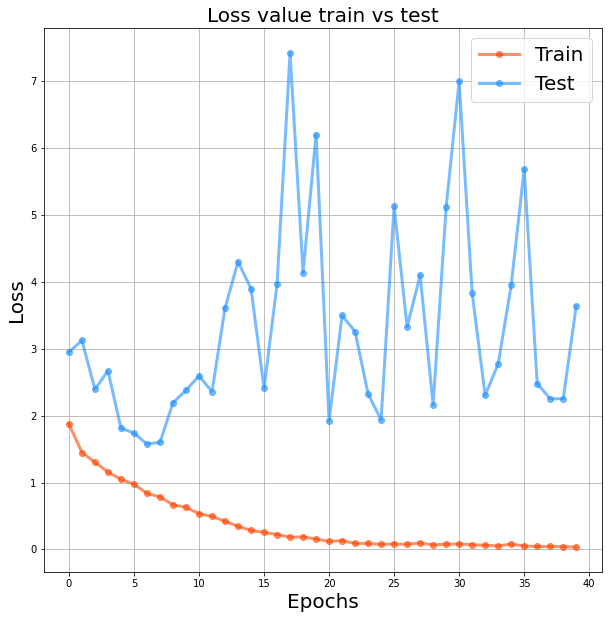

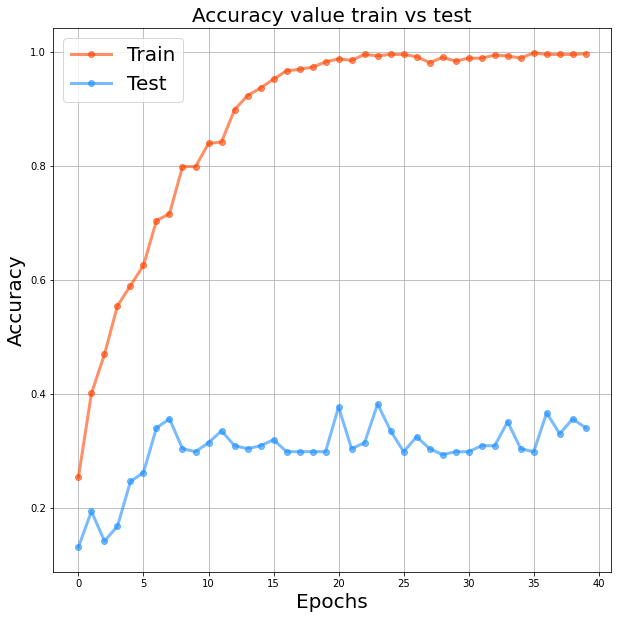

In [ ]:
X = range(nb_epoch)
plt.figure(figsize=(10,10))
plt.plot(X, history_b.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_b.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_b.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_b.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### Normal (sans Dropout ni Batchnormalization)

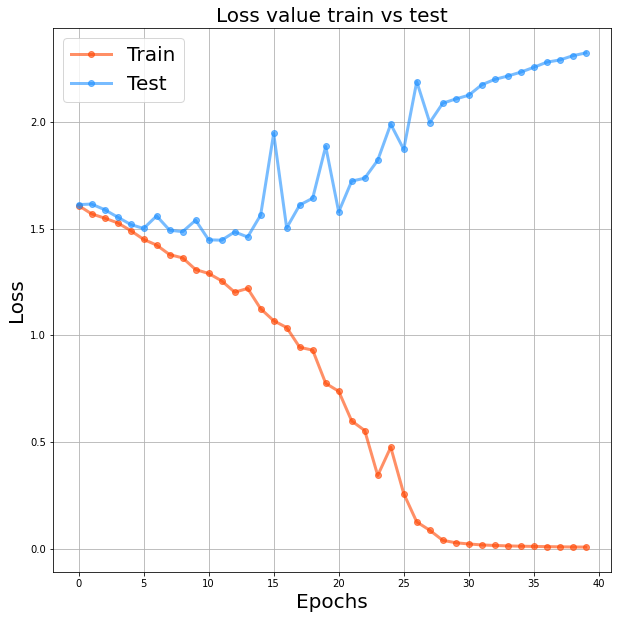

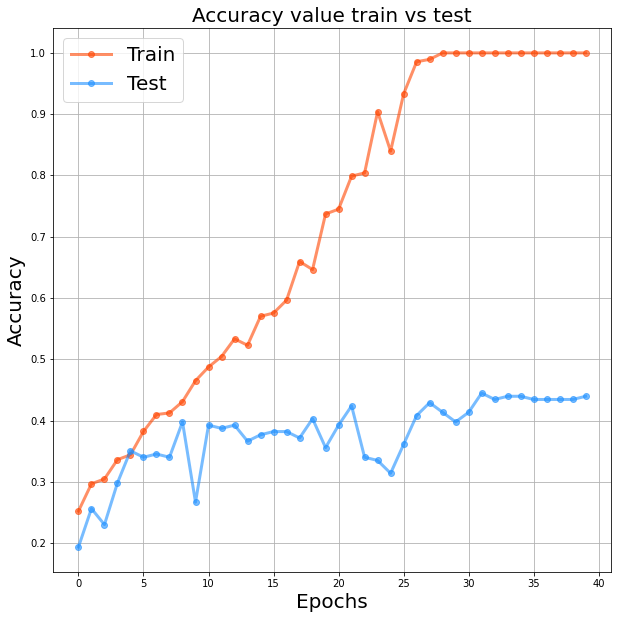

In [ ]:
X = range(nb_epoch)
plt.figure(figsize=(10,10))
plt.plot(X, history.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### Drop out

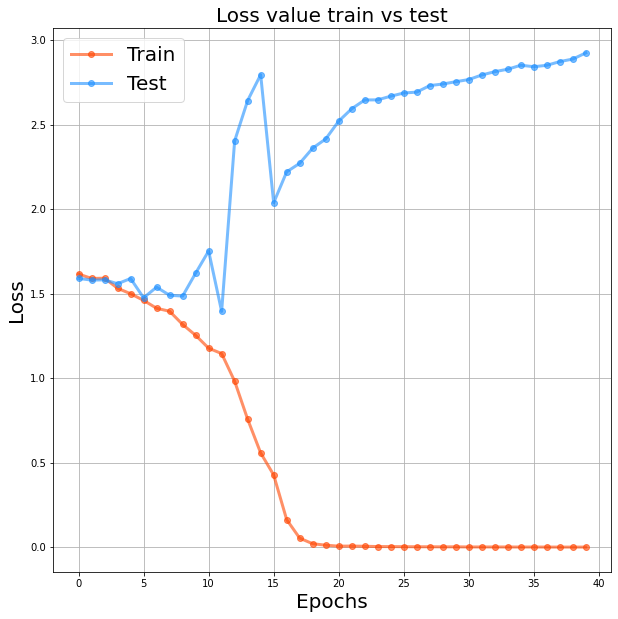

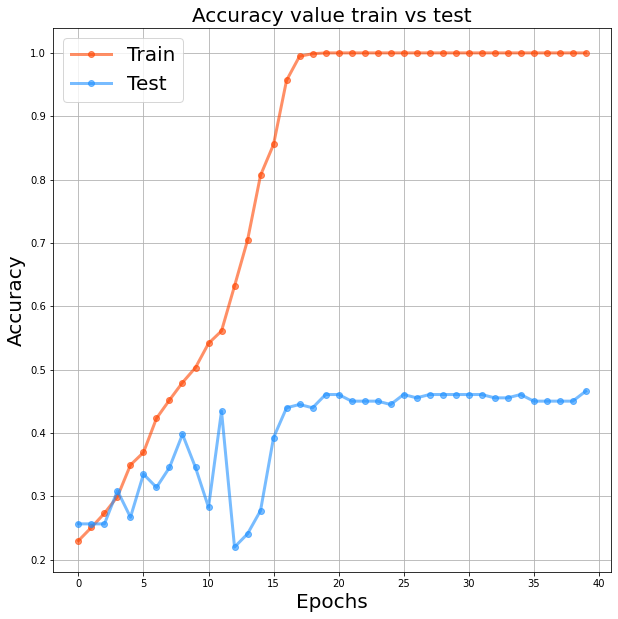

In [ ]:
X = range(nb_epoch)
plt.figure(figsize=(10,10))
plt.plot(X, history_d.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_d.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_d.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_d.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### Autres métriques confusion matrix, uniqquement pour les modèles avec et sans dropout

In [ ]:
# On récupère les prédictions du modèle sans dropout
# et les y_true
lab = ohe.categories_[0]
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(my_VGG16.predict(X_test), axis=1)
cm = confusion_matrix(y_true, y_pred)
confusion_matrix(y_true, y_pred)

array([[13,  4,  3,  6,  8],
       [ 3, 21,  4,  3,  6],
       [ 3,  4, 26,  4, 12],
       [ 1,  3,  7, 10,  6],
       [ 9,  8, 12,  4, 11]])

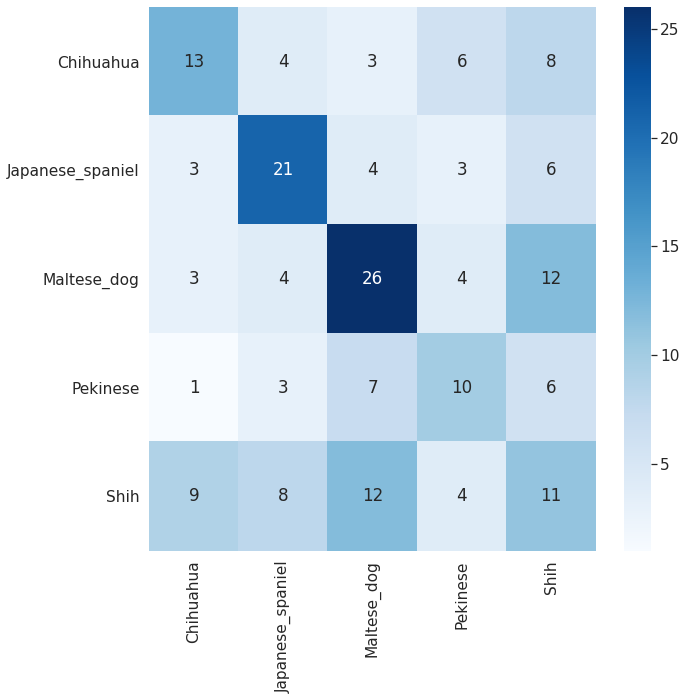

In [ ]:
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(my_VGG16_d.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)
confusion_matrix(y_true_d, y_pred_d)

array([[12,  3,  5,  9,  5],
       [ 4, 23,  4,  2,  4],
       [ 3,  4, 29,  5,  8],
       [ 1,  1, 11,  8,  6],
       [11,  5, 11,  3, 14]])

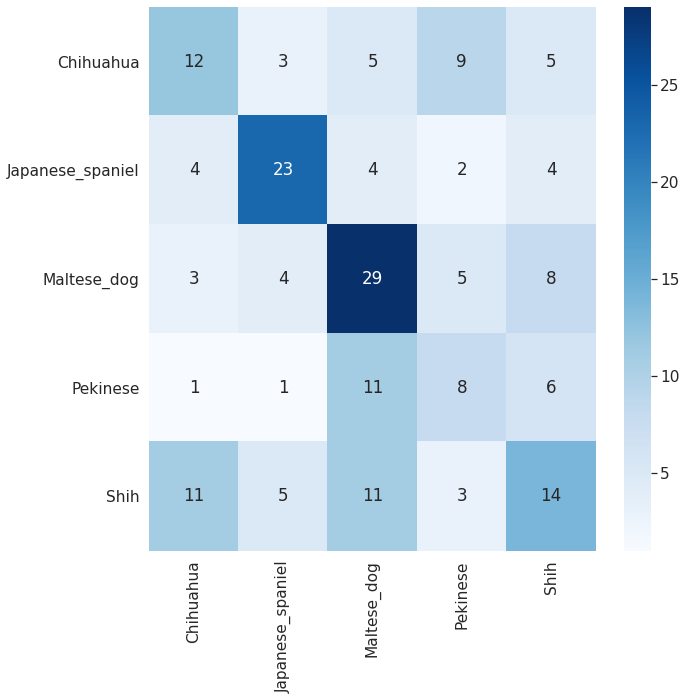

In [ ]:
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

In [ ]:
# Comparasion f1_score, On obtient des score identiques
print("F1 score modèle sans dropout: ",f1_score(y_true, y_pred, average='weighted'))
print("F1 score modèle avec dropout: ",f1_score(y_true_d, y_pred_d, average='weighted'))

F1 score modèle sans dropout:  0.44582296170481445
F1 score modèle avec dropout:  0.44582296170481445


### Augementation de donnée: on augmente artificellement le nombre de données avec ImageDataGenerator. on applique aux photos originals les transformées suivantes, translation haut/bas, rotation, flip horizontal, zoom.  

In [ ]:
data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

In [ ]:
# On génère un nouveau jeu de donnée
# pour chaque photo on produit de nouvelles
# photo zoomer avec rotation etc... 
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit')
dirimg = os.listdir()

for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = Image.open(img)
        im = np.array(im)
        im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2])) 
        count = 0
        for batch in data_gen.flow(im, batch_size=1, save_prefix='dog', save_to_dir='/content/drive/My Drive/Colab Notebooks/dataset reduit gen/'+folder, save_format='jpeg'):
          count+=1
          if count==5:
            break
    os.chdir('../')
    print(folder)
os.chdir('/content/drive/My Drive/Colab Notebooks/')

n02085936-Maltese_dog
n02085782-Japanese_spaniel
n02086240-Shih-Tzu
n02085620-Chihuahua
n02086079-Pekinese


### On vient récuperer les nouvelles données (photo orginales + photo génerées) => nouveau répertoire

In [ ]:
picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit gen')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = Image.open(img)
        im = im.filter(ImageFilter.MedianFilter(size=3))
        im = autocontrast(im)
        im = equalize(im)
        im = im.resize((224, 224))
        im = np.array(im)/255
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
# Split
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

### On réapprend nos modèles avec et sans dropout sur les données augmentées

In [ ]:
# On récupère les meilleurs hyperparamètres pour la version dropout
activation = 'tanh'#clsBest.best_params_['activation']
batch_size = 10 #clsBest.best_params_['batch_size']
dropout_rate = clsBest.best_params_['dropout_rate']
nb_epoch = 40  # clsBest.best_params_['nb_epoch']
optimizer = 'sgd' #clsBest.best_params_['optimizer']

my_VGG16_dd = Sequential()
my_VGG16_dd.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
my_VGG16_dd.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
my_VGG16_dd.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16_dd.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
my_VGG16_dd.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_dd.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_dd.add(Flatten())
my_VGG16_dd.add(Dense(1024, activation=activation))
my_VGG16_dd.add(Dense(512, activation=activation))
my_VGG16_dd.add(Dense(256, activation=activation))
my_VGG16_dd.add(Dense(128, activation=activation))
my_VGG16_dd.add(Dense(64, activation=activation))
my_VGG16_dd.add(Dense(5, activation='softmax'))
my_VGG16_dd.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history_dd = my_VGG16_dd.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
440/440 [==============================] - 18s 38ms/step - loss: 1.5643 - accuracy: 0.2980 - val_loss: 1.4587 - val_accuracy: 0.3758
Epoch 2/40
440/440 [==============================] - 16s 37ms/step - loss: 1.4161 - accuracy: 0.4161 - val_loss: 1.4319 - val_accuracy: 0.3995
Epoch 3/40
440/440 [==============================] - 16s 37ms/step - loss: 1.3130 - accuracy: 0.4797 - val_loss: 1.4462 - val_accuracy: 0.4277
Epoch 4/40
440/440 [==============================] - 16s 37ms/step - loss: 1.2312 - accuracy: 0.5148 - val_loss: 1.3679 - val_accuracy: 0.4249
Epoch 5/40
440/440 [==============================] - 16s 37ms/step - loss: 1.0338 - accuracy: 0.5991 - val_loss: 1.5604 - val_accuracy: 0.4340
Epoch 6/40
440/440 [==============================] - 16s 37ms/step - loss: 0.8424 - accuracy: 0.6913 - val_loss: 2.2790 - val_accuracy: 0.2985
Epoch 7/40
440/440 [==============================] - 16s 37ms/step - loss: 0.5959 - accuracy: 0.7826 - val_loss: 1.8120 - val_accuracy:

In [ ]:
# On récupère les meilleurs hyperparamètres pour la version dropout
activation = 'tanh'#clsBest.best_params_['activation']
batch_size = 10 #clsBest.best_params_['batch_size']
dropout_rate = 0.3 #clsBest.best_params_['dropout_rate']
nb_epoch = 40  # clsBest.best_params_['nb_epoch']
optimizer = 'sgd' #clsBest.best_params_['optimizer']

my_VGG16_dd2 = Sequential()
my_VGG16_dd2.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
my_VGG16_dd2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) 
my_VGG16_dd2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
my_VGG16_dd2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
my_VGG16_dd2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_dd2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
my_VGG16_dd2.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
my_VGG16_dd2.add(Flatten())
my_VGG16_dd2.add(Dense(1024, activation=activation))
my_VGG16_dd2.add(Dropout(dropout_rate))
my_VGG16_dd2.add(Dense(512, activation=activation))
my_VGG16_dd2.add(Dropout(dropout_rate))
my_VGG16_dd2.add(Dense(256, activation=activation))
my_VGG16_dd2.add(Dropout(dropout_rate))
my_VGG16_dd2.add(Dense(128, activation=activation))
my_VGG16_dd2.add(Dropout(dropout_rate))
my_VGG16_dd2.add(Dense(64, activation=activation))
my_VGG16_dd2.add(Dropout(dropout_rate))
my_VGG16_dd2.add(Dense(5, activation='softmax'))
my_VGG16_dd2.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history_dd2 = my_VGG16_dd2.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
440/440 [==============================] - 18s 38ms/step - loss: 1.6099 - accuracy: 0.2466 - val_loss: 1.5855 - val_accuracy: 0.2748
Epoch 2/40
440/440 [==============================] - 16s 37ms/step - loss: 1.5634 - accuracy: 0.2954 - val_loss: 1.4529 - val_accuracy: 0.4213
Epoch 3/40
440/440 [==============================] - 16s 37ms/step - loss: 1.4670 - accuracy: 0.3705 - val_loss: 1.6133 - val_accuracy: 0.2884
Epoch 4/40
440/440 [==============================] - 16s 37ms/step - loss: 1.4321 - accuracy: 0.3932 - val_loss: 1.4276 - val_accuracy: 0.4104
Epoch 5/40
440/440 [==============================] - 16s 37ms/step - loss: 1.3861 - accuracy: 0.4433 - val_loss: 1.4239 - val_accuracy: 0.3904
Epoch 6/40
440/440 [==============================] - 16s 37ms/step - loss: 1.3294 - accuracy: 0.4496 - val_loss: 1.3027 - val_accuracy: 0.4741
Epoch 7/40
440/440 [==============================] - 16s 37ms/step - loss: 1.2305 - accuracy: 0.5171 - val_loss: 1.4186 - val_accuracy:

# Affichage des courbes Loss et Accuracy (données augmentées)

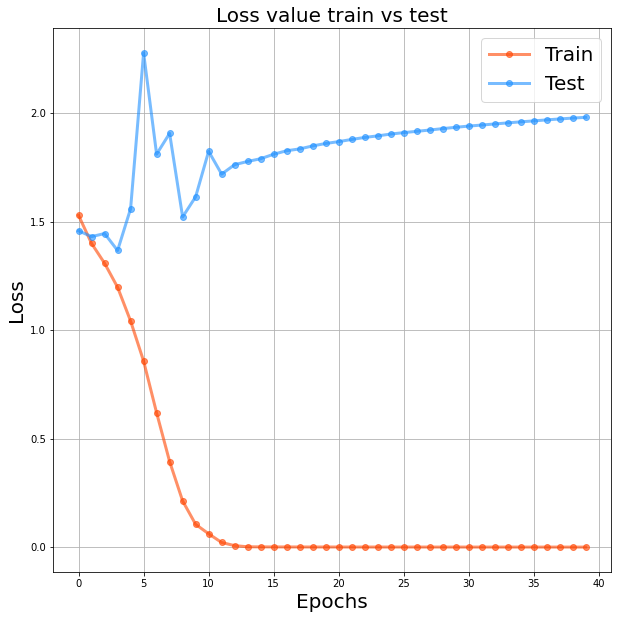

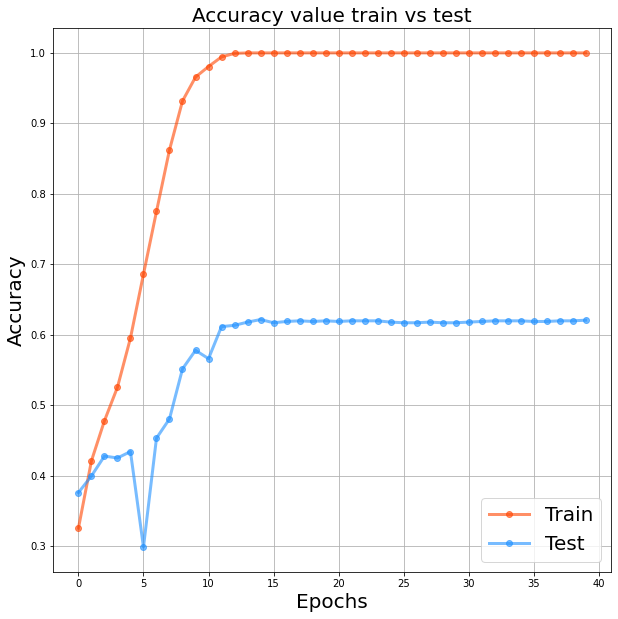

In [ ]:
X = range(40)
plt.figure(figsize=(10,10))
plt.plot(X, history_dd.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_dd.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_dd.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_dd.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

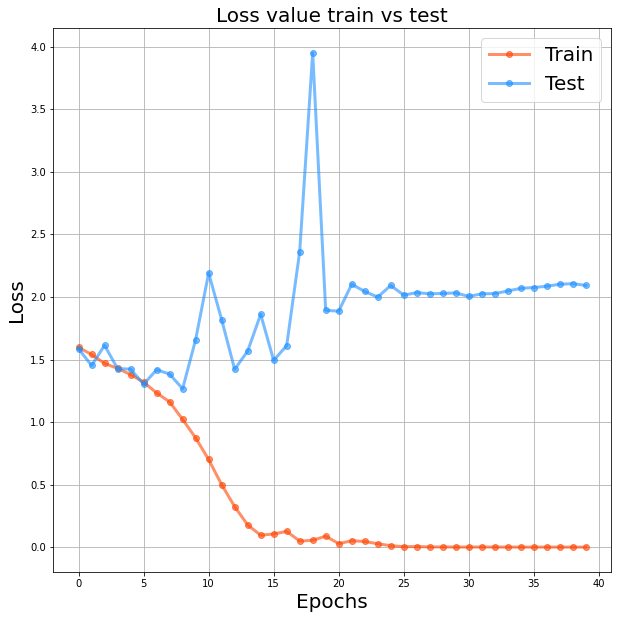

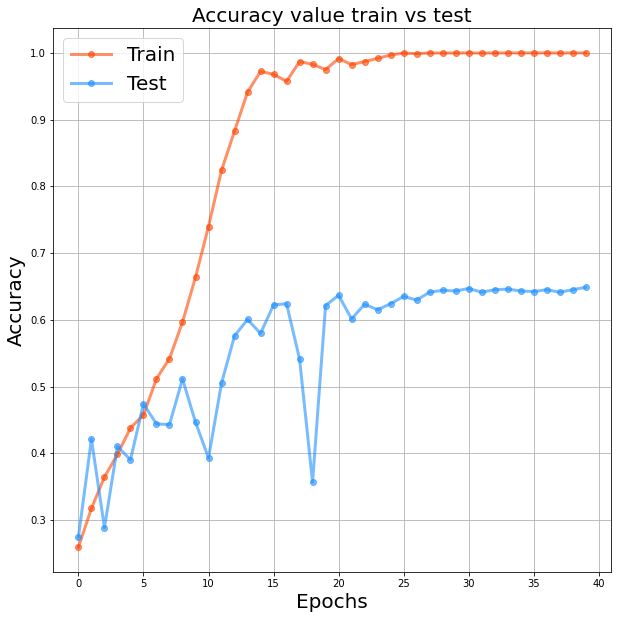

In [ ]:
X = range(40)
plt.figure(figsize=(10,10))
plt.plot(X, history_dd2.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_dd2.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_dd2.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_dd2.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

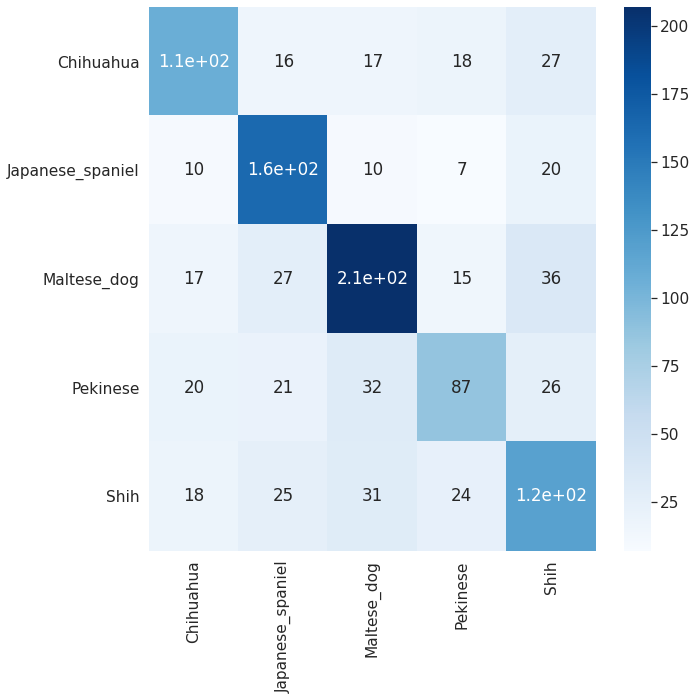

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(my_VGG16_dd.predict(X_test), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

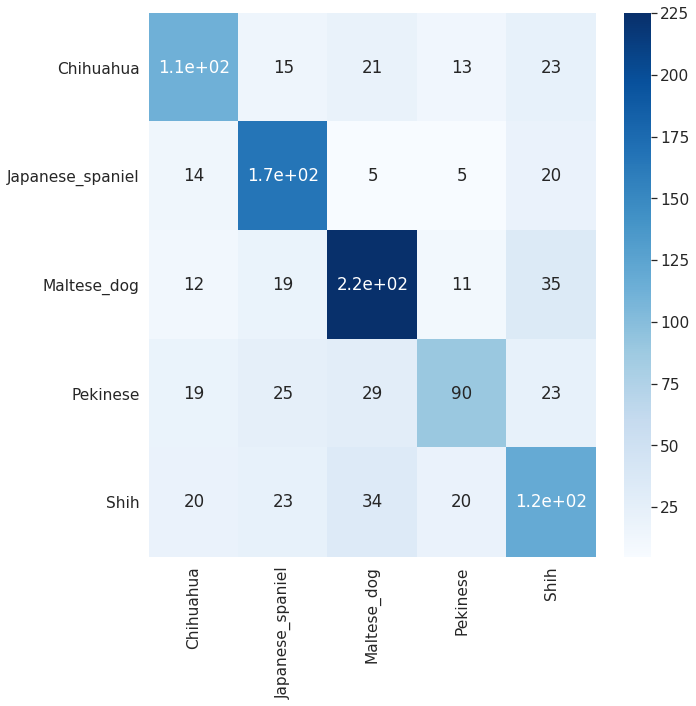

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(my_VGG16_dd2.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

In [ ]:
# Comparasion f1_score avec et sans Dropout
print("F1 score modèle sans dropout: ",f1_score(y_true, y_pred, average='weighted'))
print("F1 score modèle avec dropout: ",f1_score(y_true_d, y_pred_d, average='weighted'))

F1 score modèle sans dropout:  0.6177539965970369
F1 score modèle avec dropout:  0.6450834051043595


### f1_score augmente signitivement: on passe de 0.44 a 0.64 

In [ ]:
'''
# INFOS MATERIEL UTILISE
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
!cat /proc/cpuinfo
!cat /proc/meminfo
'''

'\nfrom tensorflow.python.client import device_lib\ndevice_lib.list_local_devices()\n!cat /proc/cpuinfo\n!cat /proc/meminfo\n'

# Transfer Learning

### On traite les données avec les outils Keras

In [ ]:
# Récupération des données

picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = load_img(img, target_size=(224, 224))
        #im = load_img(img, target_size=(299, 299))
        im = img_to_array(im)
        #im = np.expand_dims(im, axis=0)
        #print(im)
        im = preprocess_input(im)
        #print(im)
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

### On split les données

In [ ]:
# Split 
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

### On définit un modèle a partir du VGG16 déjà entrainé
### plusieurs possibilités ont été testées: 
### -fine tunning partiel 
### -extraction de feature
### imagent comprend beaucoup d'image de chiens de différentes races => les featues complexes n'ont pas besoin d'êtres réapprises => pas d'extraction de features.
### on ne remplace que la couche fully-connected:
### -directement par une couche softmax
### -en changant la tailles des couches puis alternance avec dropout
### -en ne remplacant que la couche de sortie
### Après plusieurs tentatives, la solution qui consiste a ne modifier que la dernière couche offre les meilleurs résultats, les temps d'apprentissages sont également plus court. On conserve donc cette solution.



### On réalise quand même un test avec la couche fully connected remplacé par 
### une simple couche softmax.

In [ ]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
    layer.trainable = False


flat = Flatten()(model.layers[-1].output)
#x = Dense(1024, activation='relu')(flat)
#x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
x = Dense(5, activation='softmax')(flat)
    

new_model = Model(inputs=model.input, outputs=x)
new_model.compile(optimizer='sgd', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
# Configuration du réseau
new_model.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

### On fit le réseau sur nos données disponibles

In [ ]:
history = new_model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/20
77/77 [==============================] - 5s 44ms/step - loss: 1017.2926 - accuracy: 0.5905 - val_loss: 700.9387 - val_accuracy: 0.7696
Epoch 2/20
77/77 [==============================] - 3s 38ms/step - loss: 186.7280 - accuracy: 0.9048 - val_loss: 191.8750 - val_accuracy: 0.8848
Epoch 3/20
77/77 [==============================] - 3s 37ms/step - loss: 32.5191 - accuracy: 0.9708 - val_loss: 254.6331 - val_accuracy: 0.8901
Epoch 4/20
77/77 [==============================] - 3s 37ms/step - loss: 15.2025 - accuracy: 0.9893 - val_loss: 249.6076 - val_accuracy: 0.8953
Epoch 5/20
77/77 [==============================] - 3s 37ms/step - loss: 33.0213 - accuracy: 0.9700 - val_loss: 196.1236 - val_accuracy: 0.9110
Epoch 6/20
77/77 [==============================] - 3s 38ms/step - loss: 0.7648 - accuracy: 0.9976 - val_loss: 214.1389 - val_accuracy: 0.9215
Epoch 7/20
77/77 [==============================] - 3s 37ms/step - loss: 2.2765 - accuracy: 0.9963 - val_loss: 231.4976 - val_accuracy

### Affichage des courbes

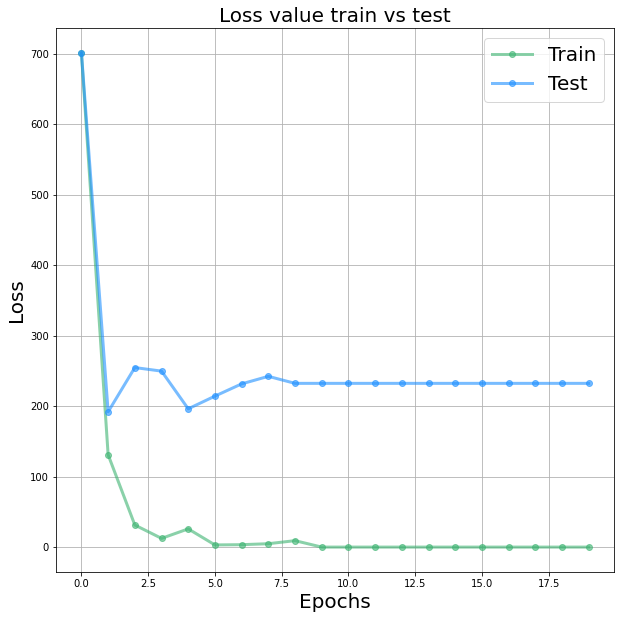

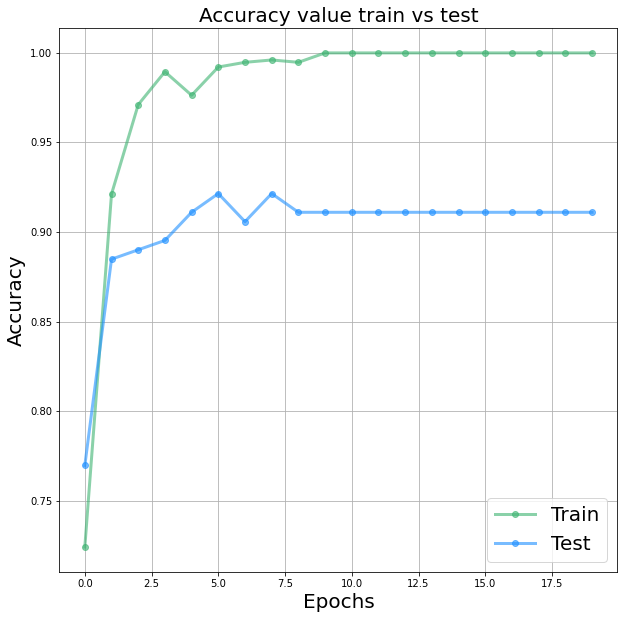

In [ ]:
X = range(20)
plt.figure(figsize=(10,10))
plt.plot(X, history.history['loss'], color='mediumseagreen', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history.history['accuracy'], color='mediumseagreen', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### On repart sur le modèle avec uniquement la couche de sortie modifiée.
### Grille de recherche sur size batch et optimizer

In [ ]:
def model(optimizer='sgd'):

   #optimizer = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
   #adm = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
   model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

   for layer in model.layers:
      layer.trainable = False

   #flat = Flatten()(model.layers[-1].output)
   #x = Dense(1024, activation='relu')(flat)
   #x = Dense(100, activation='relu')(x)
   #x = Dense(256, activation='relu')(x)
   #x = Dense(128, activation='relu')(x)
   #x = Dense(64, activation='relu')(x)
   x = Dense(5, activation='softmax')(model.layers[-2].output)
      
   new_model = Model(inputs=model.input, outputs=x)
   new_model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
   return new_model

In [ ]:
#sgd = SGD(learning_rate=0.01, momentum=0.0, decay=0.0, nesterov=False)
#adm = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

tuned_parameters = {'optimizer': ['sgd', 'adam', 'rmsprop', 'adamax'],
                    'nb_epoch': [12],
                    'batch_size': [5, 10, 20, 30]}

In [ ]:
# Stratified Cross Validation
Ti = time.time()
#cv = StratifiedKFold(n_splits=2)
cv = KFold(n_splits=2)

# On utilise le wrapper scikit learn par keras
# de manière a utiliser GrisSerachCV
modelk = KerasClassifier(build_fn=model)

# Grille de recherche, retourne le meilleur classifieur
clsBest = GridSearchCV(estimator=modelk, param_grid=tuned_parameters, cv=cv, n_jobs = 1)
clsBest.fit(X_train, y_train)

Tf = time.time()
print(Tf - Ti)

77/77 [==============================] - 4s 32ms/step - loss: 0.8132 - accuracy: 0.7355
205.05008816719055


### Affichage les meilleurs hyperparamètres

In [ ]:
pd.DataFrame(clsBest.cv_results_).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_nb_epoch,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,4.075617,0.030900,1.815414,0.018637,10,12,adam,"{'batch_size': 10, 'nb_epoch': 12, 'optimizer'...",0.900262,0.902632,0.901447,0.001185,1
9,4.138272,0.066733,1.729223,0.073118,20,12,adam,"{'batch_size': 20, 'nb_epoch': 12, 'optimizer'...",0.879265,0.900000,0.889633,0.010367,2
1,4.385848,0.077309,2.018225,0.036797,5,12,adam,"{'batch_size': 5, 'nb_epoch': 12, 'optimizer':...",0.897638,0.876316,0.886977,0.010661,3
3,4.389366,0.098622,2.002569,0.041453,5,12,adamax,"{'batch_size': 5, 'nb_epoch': 12, 'optimizer':...",0.876640,0.886842,0.881741,0.005101,4
13,3.744837,0.012476,1.439649,0.012493,30,12,adam,"{'batch_size': 30, 'nb_epoch': 12, 'optimizer'...",0.860892,0.889474,0.875183,0.014291,5
6,4.094234,0.048885,1.768321,0.016138,10,12,rmsprop,"{'batch_size': 10, 'nb_epoch': 12, 'optimizer'...",0.866142,0.871053,0.868597,0.002455,6
7,4.063230,0.050757,1.829624,0.015730,10,12,adamax,"{'batch_size': 10, 'nb_epoch': 12, 'optimizer'...",0.847769,0.876316,0.862042,0.014273,7
11,4.302881,0.172740,1.679968,0.000896,20,12,adamax,"{'batch_size': 20, 'nb_epoch': 12, 'optimizer'...",0.853018,0.871053,0.862035,0.009017,8
2,4.406703,0.045575,2.023431,0.059206,5,12,rmsprop,"{'batch_size': 5, 'nb_epoch': 12, 'optimizer':...",0.874016,0.850000,0.862008,0.012008,9
14,4.141538,0.005247,1.826244,0.010557,30,12,rmsprop,"{'batch_size': 30, 'nb_epoch': 12, 'optimizer'...",0.842520,0.873684,0.858102,0.015582,10


### On lance une grille de recherche sur les hyperparamètres du meilleur optimizer: Adam

In [ ]:
# def model(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0):
def model(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0):

   #optimizer = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
   #adm = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
   model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

   for layer in model.layers:
      layer.trainable = False

   flat = Flatten()(model.layers[-1].output)
   #x = Dense(1024, activation='relu')(flat)
   #x = Dense(100, activation='relu')(x)
   #x = Dense(256, activation='relu')(x)
   #x = Dense(128, activation='relu')(x)
   #x = Dense(64, activation='relu')(x)
   x = Dense(5, activation='softmax')(model.layers[-2].output)#(model.layers[-2].output)

   #optimizer = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, decay=decay)
   optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
   new_model = Model(inputs=model.input, outputs=x)
   new_model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])
   return new_model

In [ ]:
# Adam

tuned_parameters = {'learning_rate': [0.001, 0.0001],
                    'beta_1': [0.9, 0.7],
                    'beta_2': [0.99, 0.9],
                    'epsilon': [1e-08, 1e-09],
                    'decay': [0.0, 0.01], 
                    'nb_epoch': [12],
                    'batch_size': [5]}

In [ ]:
# Stratified Cross Validation
Ti = time.time()
#cv = StratifiedKFold(n_splits=2)
cv = KFold(n_splits=2)

# On utilise le wrapper scikit learn par keras
# de manière a utiliser GrisSerachCV
modelk = KerasClassifier(build_fn=model)

# Grille de recherche, retourne le meilleur classifieur
clsBest = GridSearchCV(estimator=modelk, param_grid=tuned_parameters, cv=cv, n_jobs = 1)
clsBest.fit(X_train, y_train)

Tf = time.time()
print(Tf - Ti)

153/153 [==============================] - 4s 20ms/step - loss: 0.8874 - accuracy: 0.7383
474.07709074020386


### Affichage des meilleurs hyperparamètres pour l'optimiseur rmsprop

In [ ]:
df = pd.DataFrame(clsBest.cv_results_).sort_values(by=['rank_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_beta_1,param_beta_2,param_decay,param_epsilon,param_learning_rate,param_nb_epoch,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,5.119460,0.309863,2.568850,0.516405,5,0.9,0.99,0.01,1e-09,0.001,12,"{'batch_size': 5, 'beta_1': 0.9, 'beta_2': 0.9...",0.897638,0.910526,0.904082,0.006444,1
16,5.696739,0.305427,2.018039,0.016374,5,0.7,0.99,0,1e-08,0.001,12,"{'batch_size': 5, 'beta_1': 0.7, 'beta_2': 0.9...",0.908136,0.892105,0.900121,0.008016,2
10,4.895402,0.531073,2.015335,0.033353,5,0.9,0.9,0,1e-09,0.001,12,"{'batch_size': 5, 'beta_1': 0.9, 'beta_2': 0.9...",0.889764,0.907895,0.898829,0.009065,3
0,4.481862,0.086746,2.586652,0.532896,5,0.9,0.99,0,1e-08,0.001,12,"{'batch_size': 5, 'beta_1': 0.9, 'beta_2': 0.9...",0.897638,0.894737,0.896187,0.001450,4
28,4.377241,0.023473,2.579203,0.533853,5,0.7,0.9,0.01,1e-08,0.001,12,"{'batch_size': 5, 'beta_1': 0.7, 'beta_2': 0.9...",0.905512,0.886842,0.896177,0.009335,5
4,4.872019,0.544055,2.015025,0.013633,5,0.9,0.99,0.01,1e-08,0.001,12,"{'batch_size': 5, 'beta_1': 0.9, 'beta_2': 0.9...",0.879265,0.910526,0.894896,0.015631,6
22,5.508094,0.034046,2.007655,0.051426,5,0.7,0.99,0.01,1e-09,0.001,12,"{'batch_size': 5, 'beta_1': 0.7, 'beta_2': 0.9...",0.902887,0.884211,0.893549,0.009338,7
24,5.200400,0.768409,2.016621,0.005679,5,0.7,0.9,0,1e-08,0.001,12,"{'batch_size': 5, 'beta_1': 0.7, 'beta_2': 0.9...",0.871391,0.910526,0.890959,0.019568,8
30,4.896187,0.484266,2.012608,0.018119,5,0.7,0.9,0.01,1e-09,0.001,12,"{'batch_size': 5, 'beta_1': 0.7, 'beta_2': 0.9...",0.884514,0.897368,0.890941,0.006427,9
14,5.413324,0.011681,1.990750,0.049676,5,0.9,0.9,0.01,1e-09,0.001,12,"{'batch_size': 5, 'beta_1': 0.9, 'beta_2': 0.9...",0.887139,0.894737,0.890938,0.003799,10


# Validation du modèle retenue X_test

In [ ]:
# On récupère les meilleurs hyperparamètres pour l'optimiseur
learning_rate = clsBest.best_params_['learning_rate']
decay = clsBest.best_params_['decay']
epsilon = clsBest.best_params_['epsilon']
nb_epoch = clsBest.best_params_['nb_epoch']
beta_1 = clsBest.best_params_['beta_1']
beta_2 = clsBest.best_params_['beta_2']
batch_size = clsBest.best_params_['batch_size']

optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
#optimizer = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, decay=decay)  
model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model = Model(inputs=model.input, outputs=x)
new_model.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
# Configuration du réseau
new_model.summary()

Model: "model_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

### On fit le modèle

In [ ]:
history = new_model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/12
153/153 [==============================] - 6s 28ms/step - loss: 0.7690 - accuracy: 0.7723 - val_loss: 0.2822 - val_accuracy: 0.9162
Epoch 2/12
153/153 [==============================] - 4s 24ms/step - loss: 0.1558 - accuracy: 0.9618 - val_loss: 0.2322 - val_accuracy: 0.9267
Epoch 3/12
153/153 [==============================] - 4s 24ms/step - loss: 0.0495 - accuracy: 0.9829 - val_loss: 0.2271 - val_accuracy: 0.9424
Epoch 4/12
153/153 [==============================] - 4s 24ms/step - loss: 0.0301 - accuracy: 0.9924 - val_loss: 0.2278 - val_accuracy: 0.9476
Epoch 5/12
153/153 [==============================] - 4s 24ms/step - loss: 0.0190 - accuracy: 0.9981 - val_loss: 0.2271 - val_accuracy: 0.9372
Epoch 6/12
153/153 [==============================] - 4s 24ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.2376 - val_accuracy: 0.9372
Epoch 7/12
153/153 [==============================] - 4s 24ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.2163 - val_accuracy: 0.9476

### Affichage des courbes

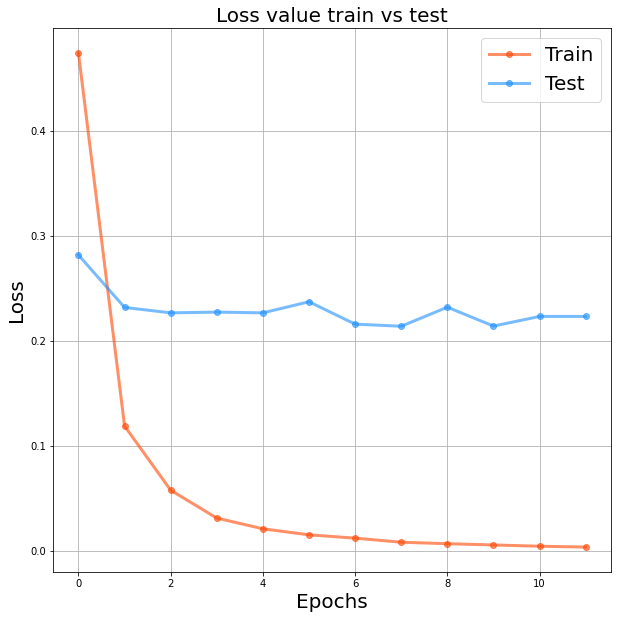

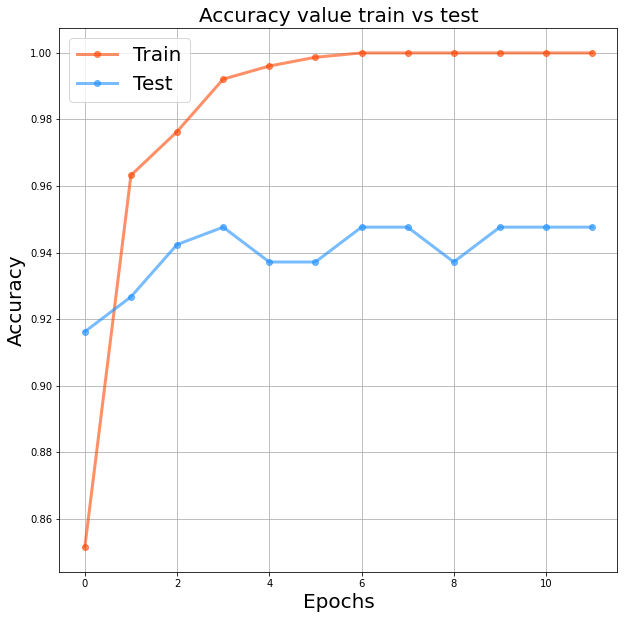

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### On test sur la base de donnée augmentée le meilleur modèle (modèle précédent)

In [ ]:
# On récupère les données augmentées

picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit gen')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = load_img(img, target_size=(224, 224))
        #im = load_img(img, target_size=(299, 299))
        im = img_to_array(im)
        #im = np.expand_dims(im, axis=0)
        #print(im)
        im = preprocess_input(im)
        #print(im)
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
# Split 
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
# On récupère les meilleurs hyperparamètres pour l'optimiseur
learning_rate = 0.001  # clsBest.best_params_['learning_rate']
decay = 0.01  # clsBest.best_params_['decay']
epsilon = 1e-09  # clsBest.best_params_['epsilon']
nb_epoch = 12  # clsBest.best_params_['nb_epoch']
beta_1 = 0.9  # clsBest.best_params_['beta_1']
beta_2 = 0.99  # clsBest.best_params_['beta_2']
batch_size = 5  # clsBest.best_params_['batch_size']

# On crée le modèle avec les meilleurs hyperparamètres
optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, decay=decay)
#optimizer = RMSprop(learning_rate=learning_rate, rho=rho, epsilon=epsilon, decay=decay)  

model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_a = Model(inputs=model.input, outputs=x)
new_model_a.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
history_a = new_model_a.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/12
879/879 [==============================] - 23s 24ms/step - loss: 0.3728 - accuracy: 0.8811 - val_loss: 0.0992 - val_accuracy: 0.9691
Epoch 2/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0626 - accuracy: 0.9787 - val_loss: 0.0759 - val_accuracy: 0.9718
Epoch 3/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0394 - accuracy: 0.9905 - val_loss: 0.0587 - val_accuracy: 0.9818
Epoch 4/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0299 - accuracy: 0.9950 - val_loss: 0.0553 - val_accuracy: 0.9854
Epoch 5/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0313 - accuracy: 0.9929 - val_loss: 0.0490 - val_accuracy: 0.9836
Epoch 6/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0239 - accuracy: 0.9954 - val_loss: 0.0447 - val_accuracy: 0.9882
Epoch 7/12
879/879 [==============================] - 20s 23ms/step - loss: 0.0209 - accuracy: 0.9973 - val_loss: 0.0419 - val_accuracy:

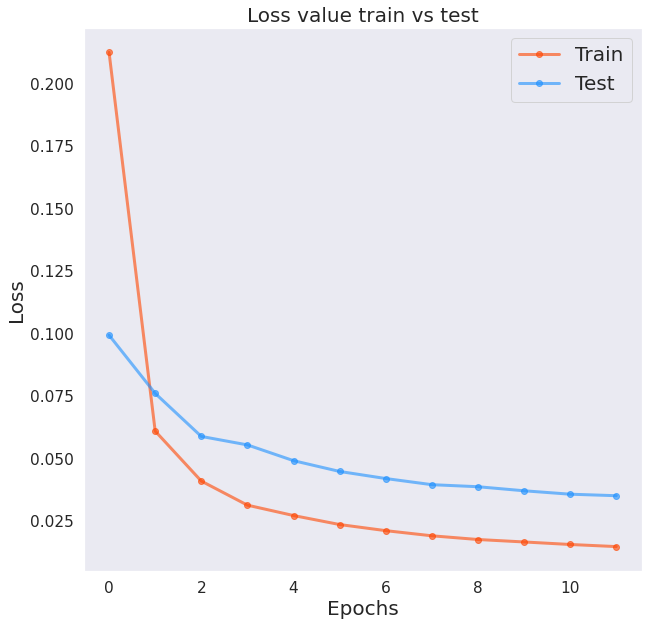

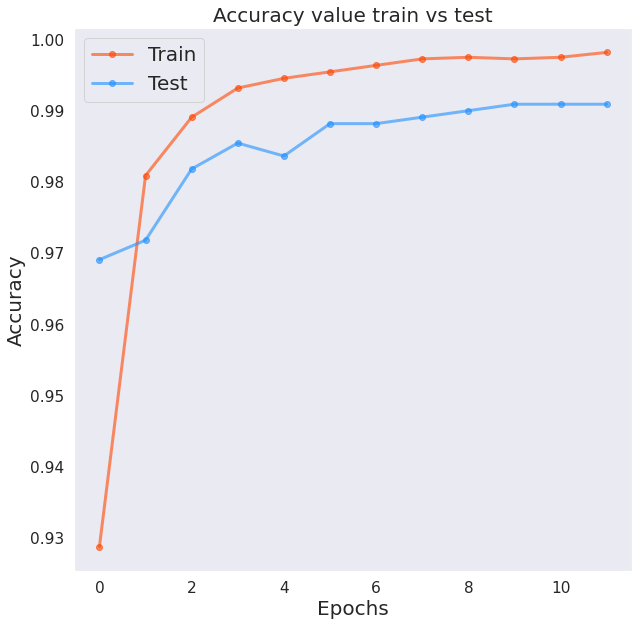

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_a.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_a.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_a.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_a.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

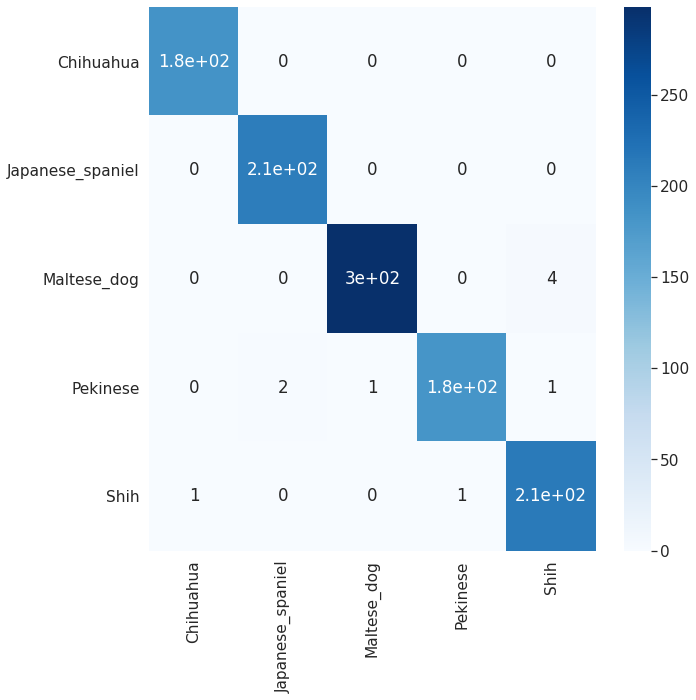

In [ ]:
# On récupère les prédictions du modèle
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(new_model_a.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

# Autres réseaux (idem pour les autres réseaux, on ne remplace que la couche de sortie).

### Resnet

In [ ]:
# Resnet 

model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_resnet = Model(inputs=model.input, outputs=x)
new_model_resnet.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

179658752/179648224 [==============================] - 5s 0us/step


In [ ]:
new_model_resnet.summary()

Model: "model_144"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_146[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
history_resnet = new_model_resnet.fit(X_train, y_train, epochs=12, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/12
77/77 [==============================] - 29s 143ms/step - loss: 1.1313 - accuracy: 0.5898 - val_loss: 0.2296 - val_accuracy: 0.9162
Epoch 2/12
77/77 [==============================] - 4s 51ms/step - loss: 0.1481 - accuracy: 0.9563 - val_loss: 0.1799 - val_accuracy: 0.9319
Epoch 3/12
77/77 [==============================] - 4s 52ms/step - loss: 0.0993 - accuracy: 0.9730 - val_loss: 0.1960 - val_accuracy: 0.9319
Epoch 4/12
77/77 [==============================] - 4s 51ms/step - loss: 0.0771 - accuracy: 0.9839 - val_loss: 0.1572 - val_accuracy: 0.9319
Epoch 5/12
77/77 [==============================] - 4s 58ms/step - loss: 0.0449 - accuracy: 0.9932 - val_loss: 0.1539 - val_accuracy: 0.9372
Epoch 6/12
77/77 [==============================] - 4s 52ms/step - loss: 0.0316 - accuracy: 0.9984 - val_loss: 0.1808 - val_accuracy: 0.9372
Epoch 7/12
77/77 [==============================] - 4s 51ms/step - loss: 0.0393 - accuracy: 0.9965 - val_loss: 0.1663 - val_accuracy: 0.9424
Epoch 8/12


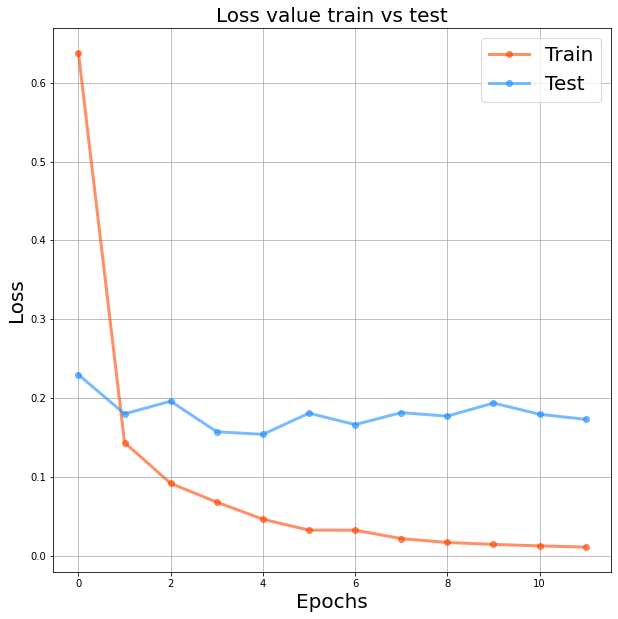

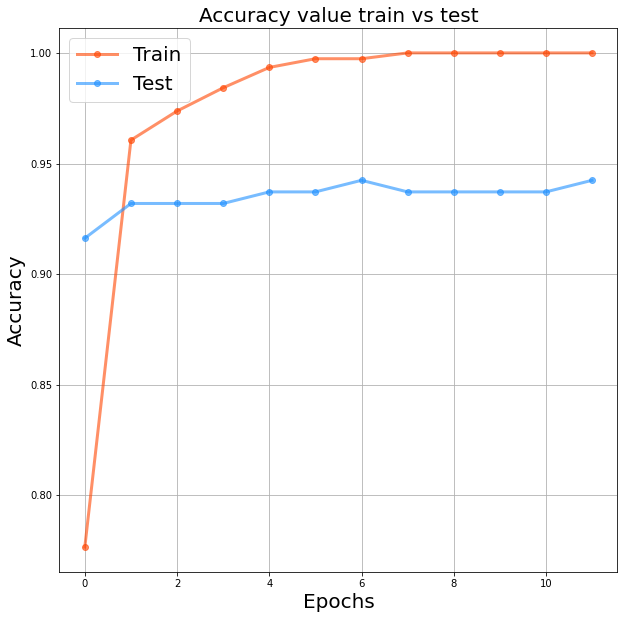

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_resnet.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_resnet.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

### Resnet with data augmentation

In [ ]:
# Resnet 

model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_resnet_a = Model(inputs=model.input, outputs=x)
new_model_resnet_a.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history_resnet_a = new_model_resnet_a.fit(X_train, y_train, epochs=12, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/12
440/440 [==============================] - 52s 71ms/step - loss: 0.4386 - accuracy: 0.8503 - val_loss: 0.1071 - val_accuracy: 0.9618
Epoch 2/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0590 - accuracy: 0.9805 - val_loss: 0.0555 - val_accuracy: 0.9827
Epoch 3/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0261 - accuracy: 0.9942 - val_loss: 0.0448 - val_accuracy: 0.9854
Epoch 4/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0144 - accuracy: 0.9980 - val_loss: 0.0328 - val_accuracy: 0.9927
Epoch 5/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0082 - accuracy: 0.9997 - val_loss: 0.0307 - val_accuracy: 0.9927
Epoch 6/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0246 - val_accuracy: 0.9918
Epoch 7/12
440/440 [==============================] - 22s 51ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy:

### Affichage courbes Resnet with data augmentation

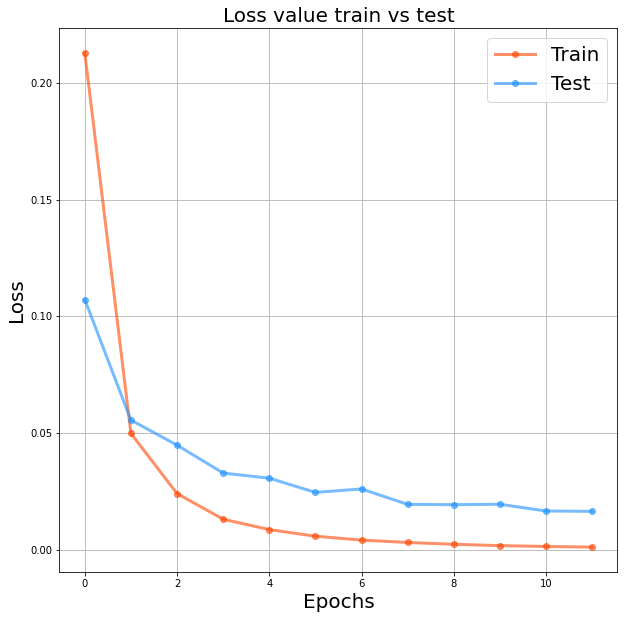

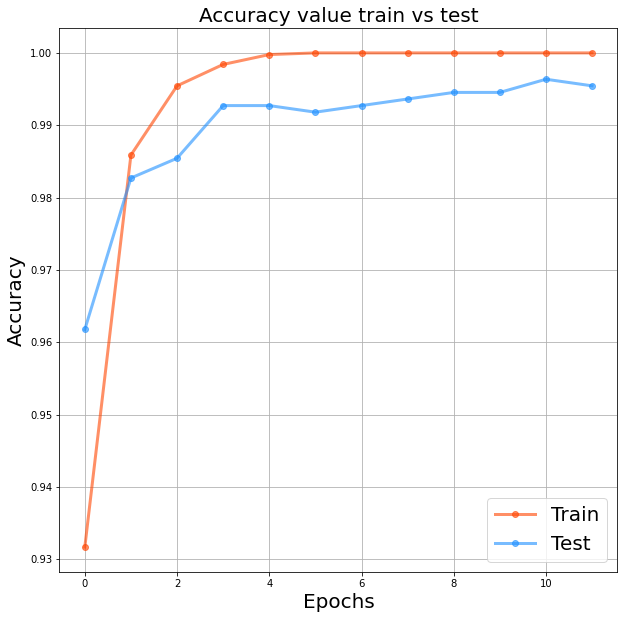

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_a.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_a.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_a.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_a.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

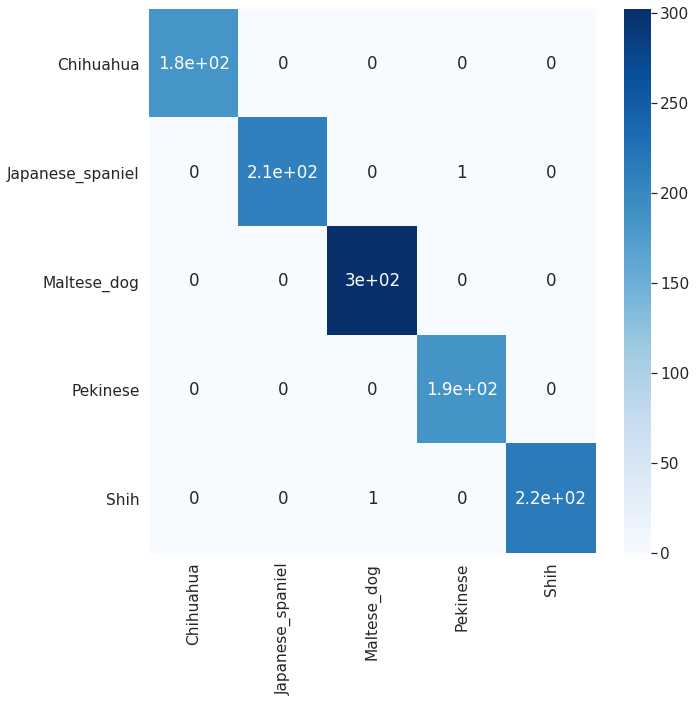

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(new_model_resnet_a.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

### Inception

In [ ]:
picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset reduit gen')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        #im = load_img(img, target_size=(224, 224))
        im = load_img(img, target_size=(299, 299))
        im = img_to_array(im)
        #im = np.expand_dims(im, axis=0)
        #print(im)
        im = preprocess_input(im)
        #print(im)
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
# Split 
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
# Inception 

model = InceptionV3(weights='imagenet', include_top=True, input_shape=(299, 299, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_inception = Model(inputs=model.input, outputs=x)
new_model_inception.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
#new_model_inception.summary()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_150 (InputLayer)          [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2033 (Conv2D)            (None, 149, 149, 32) 864         input_150[0][0]                  
__________________________________________________________________________________________________
batch_normalization_590 (BatchN (None, 149, 149, 32) 96          conv2d_2033[0][0]                
__________________________________________________________________________________________________
activation_740 (Activation)     (None, 149, 149, 32) 0           batch_normalization_590[0][0]    
_______________________________________________________________________________________

In [ ]:
# NOT USED TOO LONG to learn
history_inception = new_model_inception.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/20
440/440 [==============================] - 41s 47ms/step - loss: 8.8993 - accuracy: 0.2824 - val_loss: 4.5130 - val_accuracy: 0.4140
Epoch 2/20
440/440 [==============================] - 13s 30ms/step - loss: 4.4712 - accuracy: 0.3735 - val_loss: 3.9310 - val_accuracy: 0.3985
Epoch 3/20
440/440 [==============================] - 13s 30ms/step - loss: 3.4156 - accuracy: 0.4302 - val_loss: 2.7616 - val_accuracy: 0.4559
Epoch 4/20
440/440 [==============================] - 13s 30ms/step - loss: 2.9804 - accuracy: 0.4539 - val_loss: 2.9197 - val_accuracy: 0.4577
Epoch 5/20
440/440 [==============================] - 13s 30ms/step - loss: 3.0735 - accuracy: 0.4931 - val_loss: 3.8783 - val_accuracy: 0.4295
Epoch 6/20
440/440 [==============================] - 13s 30ms/step - loss: 2.5741 - accuracy: 0.5100 - val_loss: 6.7867 - val_accuracy: 0.3030
Epoch 7/20
440/440 [==============================] - 13s 30ms/step - loss: 3.0777 - accuracy: 0.4889 - val_loss: 4.9744 - val_accuracy:

### Dense Net

In [ ]:
# Dense net

model = DenseNet169(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_densenet = Model(inputs=model.input, outputs=x)
new_model_densenet.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

58556416/58541896 [==============================] - 1s 0us/step


In [ ]:
#new_model_densenet.summary()
model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_149 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_149[0][0]                  
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
history_densenet = new_model_densenet.fit(X_train, y_train, epochs=40, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/40
440/440 [==============================] - 85s 63ms/step - loss: 3.3798 - accuracy: 0.3217 - val_loss: 2.2338 - val_accuracy: 0.3913
Epoch 2/40
440/440 [==============================] - 13s 29ms/step - loss: 1.7708 - accuracy: 0.4644 - val_loss: 1.5343 - val_accuracy: 0.4932
Epoch 3/40
440/440 [==============================] - 13s 29ms/step - loss: 1.3882 - accuracy: 0.5516 - val_loss: 1.2681 - val_accuracy: 0.5660
Epoch 4/40
440/440 [==============================] - 13s 30ms/step - loss: 1.2198 - accuracy: 0.5931 - val_loss: 1.3519 - val_accuracy: 0.5723
Epoch 5/40
440/440 [==============================] - 13s 29ms/step - loss: 1.1767 - accuracy: 0.6199 - val_loss: 1.4257 - val_accuracy: 0.5605
Epoch 6/40
440/440 [==============================] - 13s 29ms/step - loss: 1.0280 - accuracy: 0.6549 - val_loss: 1.3561 - val_accuracy: 0.6015
Epoch 7/40
440/440 [==============================] - 13s 29ms/step - loss: 1.1647 - accuracy: 0.6422 - val_loss: 0.9856 - val_accuracy:

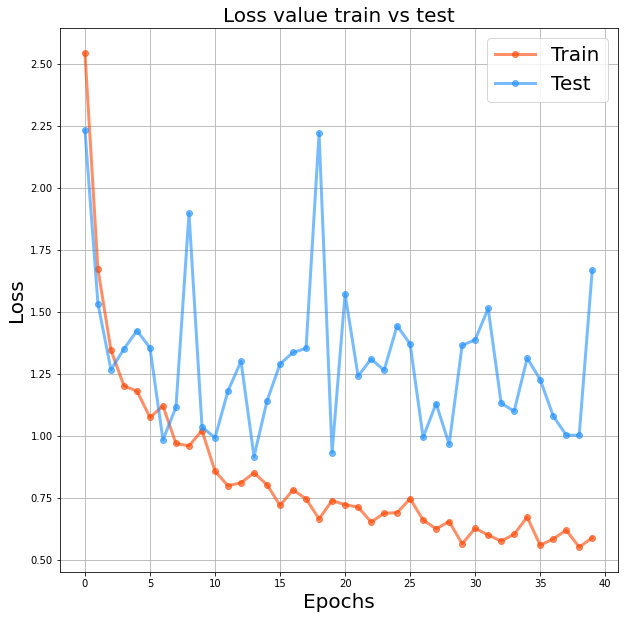

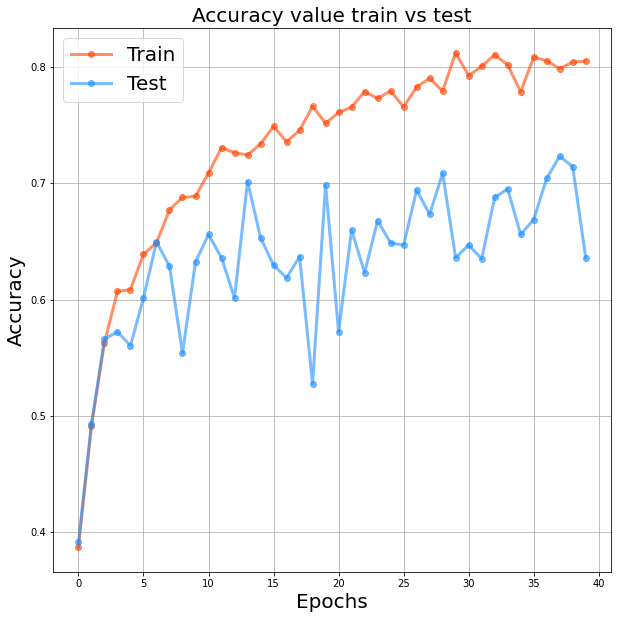

In [ ]:
X = range(40)
plt.figure(figsize=(10,10))
plt.plot(X, history_densenet.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_densenet.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_densenet.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_densenet.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

# VGG19

In [ ]:
# VGG19
model = VGG19(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(5, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_vgg19 = Model(inputs=model.input, outputs=x)
new_model_vgg19.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

574726144/574710816 [==============================] - 5s 0us/step


In [ ]:
history_vgg19 = new_model_vgg19.fit(X_train, y_train, epochs=12, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/12
440/440 [==============================] - 25s 51ms/step - loss: 0.4018 - accuracy: 0.8746 - val_loss: 0.1240 - val_accuracy: 0.9545
Epoch 2/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0435 - accuracy: 0.9849 - val_loss: 0.0535 - val_accuracy: 0.9763
Epoch 3/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0199 - accuracy: 0.9926 - val_loss: 0.0427 - val_accuracy: 0.9873
Epoch 4/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9900
Epoch 5/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0270 - val_accuracy: 0.9909
Epoch 6/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9909
Epoch 7/12
440/440 [==============================] - 20s 46ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy:

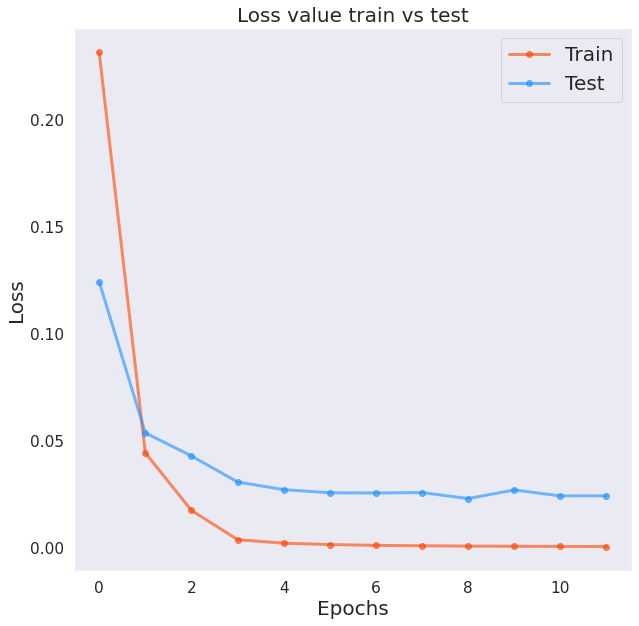

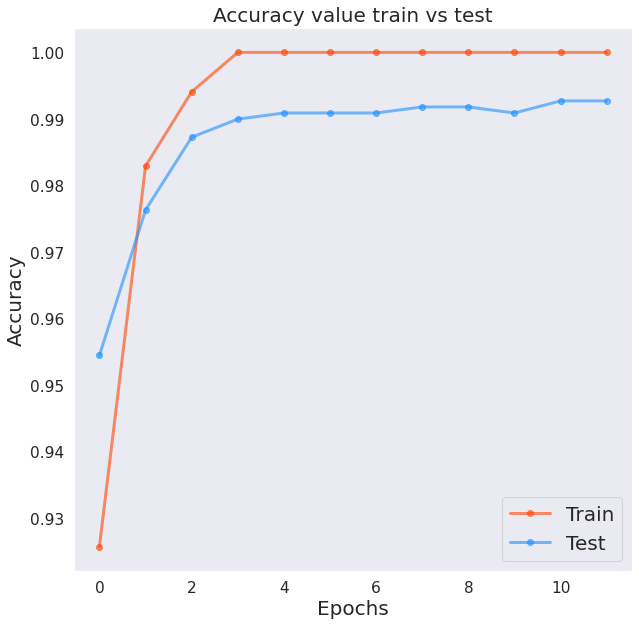

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_vgg19.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_vgg19.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_vgg19.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_vgg19.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

# On teste le meilleur reseau => RESNET sur plus de classes on passe de 5 à 12 

In [ ]:
picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset extend')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = load_img(img, target_size=(224, 224))
        #im = load_img(img, target_size=(299, 299))
        im = img_to_array(im)
        #im = np.expand_dims(im, axis=0)
        #print(im)
        im = preprocess_input(im)
        #print(im)
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
# Split 
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
# Resnet 

model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(12, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_resnet_b = Model(inputs=model.input, outputs=x)
new_model_resnet_b.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history_resnet_b = new_model_resnet_b.fit(X_train, y_train, epochs=12, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/12
184/184 [==============================] - 39s 99ms/step - loss: 1.1395 - accuracy: 0.6643 - val_loss: 0.4513 - val_accuracy: 0.8646
Epoch 2/12
184/184 [==============================] - 9s 51ms/step - loss: 0.1478 - accuracy: 0.9550 - val_loss: 0.2747 - val_accuracy: 0.9192
Epoch 3/12
184/184 [==============================] - 9s 51ms/step - loss: 0.0994 - accuracy: 0.9664 - val_loss: 0.3595 - val_accuracy: 0.8821
Epoch 4/12
184/184 [==============================] - 9s 51ms/step - loss: 0.0498 - accuracy: 0.9889 - val_loss: 0.2769 - val_accuracy: 0.9192
Epoch 5/12
184/184 [==============================] - 9s 51ms/step - loss: 0.0317 - accuracy: 0.9947 - val_loss: 0.2933 - val_accuracy: 0.9083
Epoch 6/12
184/184 [==============================] - 9s 51ms/step - loss: 0.0212 - accuracy: 0.9987 - val_loss: 0.2999 - val_accuracy: 0.9127
Epoch 7/12
184/184 [==============================] - 9s 51ms/step - loss: 0.0197 - accuracy: 0.9993 - val_loss: 0.2961 - val_accuracy: 0.917

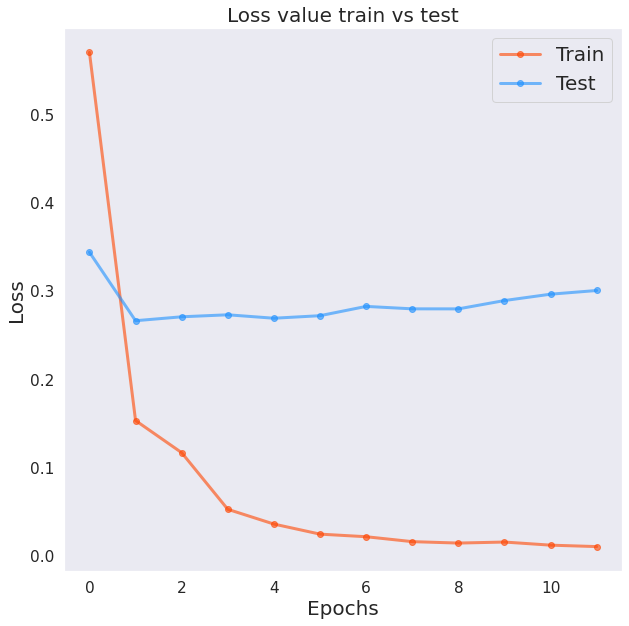

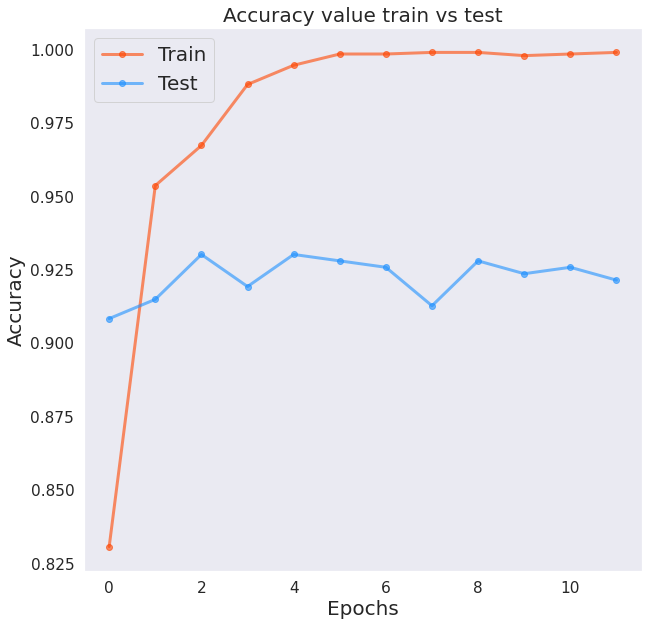

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_b.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_b.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_b.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_b.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

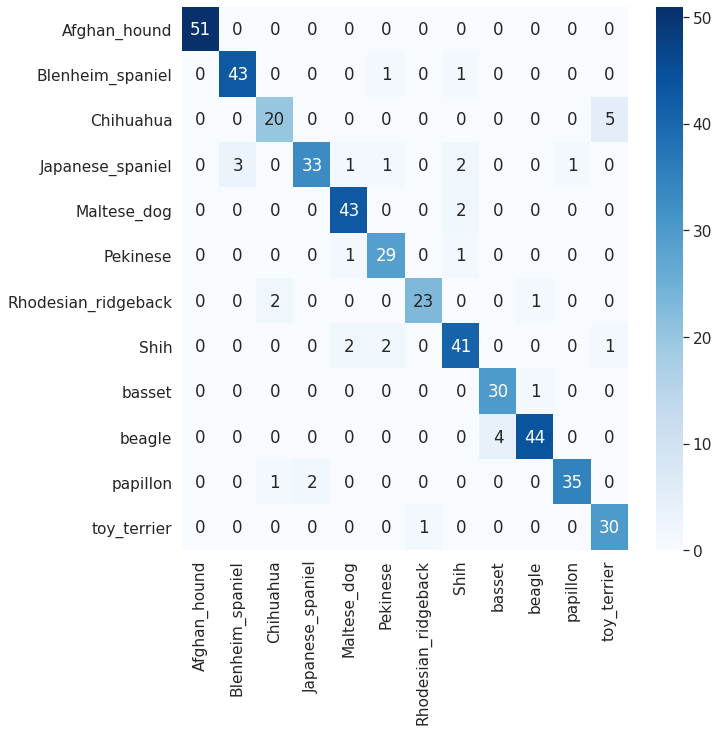

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(new_model_resnet_b.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)

plt.figure(figsize=(10,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

In [ ]:
# Comparasion f1_score
print("F1 score modèle avec dropout: ",f1_score(y_true_d, y_pred_d, average='weighted'))

F1 score modèle avec dropout:  0.9210979716133153


# Augmentation de données sur les 12 classes

In [ ]:
# On génère un nouveau jeu de données sur 12 class
 
data_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset extend')
dirimg = os.listdir()

for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = Image.open(img)
        im = np.array(im)
        im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2])) 
        count = 0
        for batch in data_gen.flow(im, batch_size=1, save_prefix='dog', save_to_dir='/content/drive/My Drive/Colab Notebooks/dataset extend gen/'+folder, save_format='jpeg'):
          count+=1
          if count==5:
            break
    os.chdir('../')
    print(folder)
os.chdir('/content/drive/My Drive/Colab Notebooks/')

n02088238-basset
n02086646-Blenheim_spaniel
n02088364-beagle
n02087394-Rhodesian_ridgeback
n02085936-Maltese_dog
n02086910-papillon
n02085782-Japanese_spaniel
n02086240-Shih-Tzu
n02088094-Afghan_hound
n02085620-Chihuahua
n02086079-Pekinese
n02087046-toy_terrier


In [ ]:
picture = []
label = []

os.chdir('/content/drive/My Drive/Colab Notebooks/dataset extend gen')
dirimg = os.listdir()
for folder in dirimg:
    os.chdir(folder)
    for img in os.listdir():
        im = load_img(img, target_size=(224, 224))
        #im = load_img(img, target_size=(299, 299))
        im = img_to_array(im)
        #im = np.expand_dims(im, axis=0)
        #print(im)
        im = preprocess_input(im)
        #print(im)
        picture.append(im)
        label.append(folder.split('-')[1])
    os.chdir('../')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [ ]:
# Split 
X = np.array(picture).astype('float32')
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

In [ ]:
# Resnet 

model = ResNet101(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

for layer in model.layers:
  layer.trainable = False

# On ne modifie que la dernière couche softmax du bloc fully connected
x = Dense(12, activation='softmax')(model.layers[-2].output)

# On définit un nouveau model
new_model_resnet_c = Model(inputs=model.input, outputs=x)
new_model_resnet_c.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
history_resnet_c = new_model_resnet_c.fit(X_train, y_train, epochs=12, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/12
1057/1057 [==============================] - 120s 61ms/step - loss: 0.5248 - accuracy: 0.8382 - val_loss: 0.1060 - val_accuracy: 0.9667
Epoch 2/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0595 - accuracy: 0.9805 - val_loss: 0.0741 - val_accuracy: 0.9743
Epoch 3/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0367 - accuracy: 0.9886 - val_loss: 0.0386 - val_accuracy: 0.9883
Epoch 4/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0192 - accuracy: 0.9956 - val_loss: 0.0638 - val_accuracy: 0.9792
Epoch 5/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0190 - accuracy: 0.9949 - val_loss: 0.0850 - val_accuracy: 0.9629
Epoch 6/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0199 - accuracy: 0.9917 - val_loss: 0.0545 - val_accuracy: 0.9792
Epoch 7/12
1057/1057 [==============================] - 54s 51ms/step - loss: 0.0239 - accuracy: 0.9907 - val_loss: 0.0219 

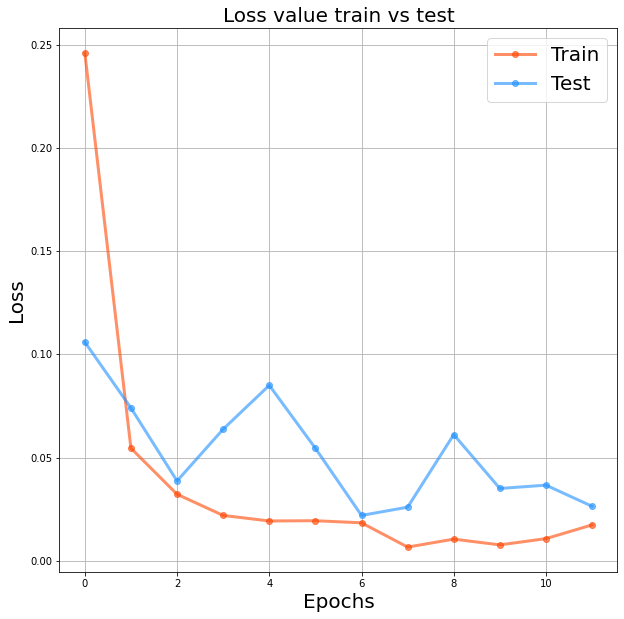

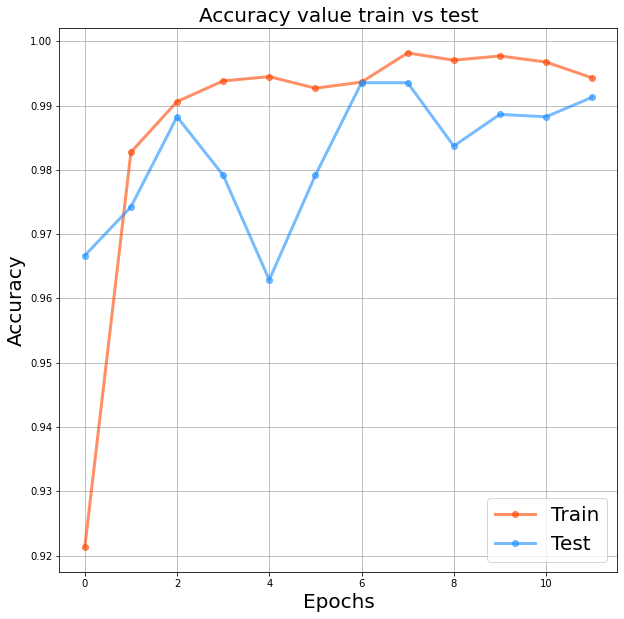

In [ ]:
X = range(12)
plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_c.history['loss'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_c.history['val_loss'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.title('Loss value train vs test', fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(X, history_resnet_c.history['accuracy'], color='orangered', linewidth=3, marker='o', alpha=0.6, label='Train')
plt.plot(X, history_resnet_c.history['val_accuracy'], color='dodgerblue', linewidth=3, marker='o', alpha=0.6, label='Test')
plt.grid()
plt.legend(fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.title('Accuracy value train vs test', fontsize=20)
plt.show()

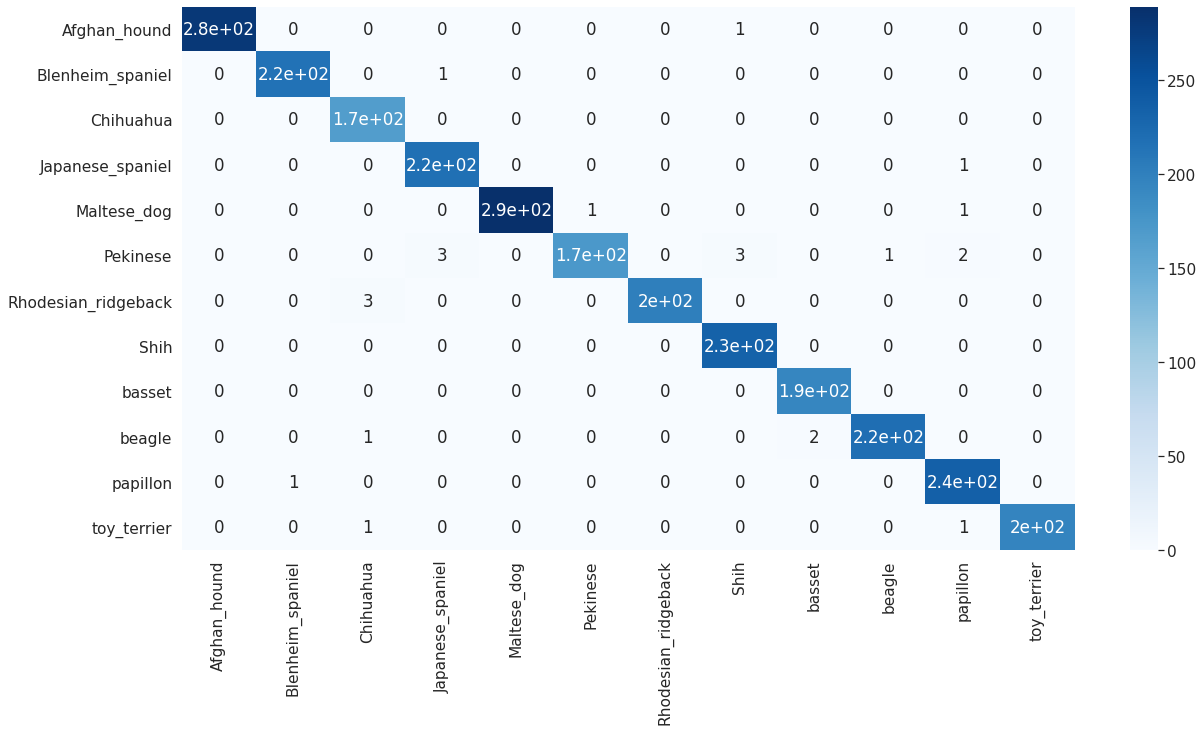

In [ ]:
# On récupère les prédictions du modèle avec dropout
# et les y_true
lab = ohe.categories_[0]
y_true_d = np.argmax(y_test, axis=1)
y_pred_d = np.argmax(new_model_resnet_c.predict(X_test), axis=1)
cm = confusion_matrix(y_true_d, y_pred_d)

plt.figure(figsize=(20,10))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True, cbar=True, cmap='Blues', xticklabels=lab, yticklabels=lab)

In [ ]:
# Comparasion f1_score
print("F1 score modèle: ",f1_score(y_true_d, y_pred_d, average='weighted'))

F1 score modèle:  0.9912756747798648


In [ ]:
# Enregistrement modèle
new_model_resnet_c.save('/content/drive/My Drive/Colab Notebooks/model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Script Test

Blenheim_spaniel


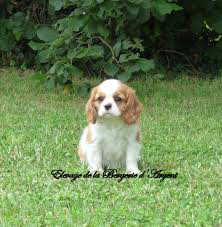

In [ ]:
import requests
from io import BytesIO

# On récupère l'image sur le web
# L'image doit appartenir a une des 12 classes de chiens: 
#'Afghan_hound' 
#'Blenheim_spaniel' 
#'Chihuahua'
#'Japanese_spaniel' 
#'Maltese_dog'
#'Pekinese'
#'Rhodesian_ridgeback' 
#'Shih'
#'basset' 
#'beagle'
#'papillon'
#'toy_terrier'

# Mettre l'URL de l'image Ex from Google
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSyw6EpcupdGLlWxG6IsxRqZeIt46uz29fSoA&usqp=CAU' # pekinois
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTn-a04TdzdTiERAkMGvK596xzFG4TvR7W8ig&usqp=CAU' # pekinois
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2I2LEWHnKQDBqp1g1HwBPh1nUgUcpmqDEow&usqp=CAU' # basset
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaKoOEsds881HpBFpXeYSlL_hqHHFycppz_Q&usqp=CAU' # beagle
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRTGyqYsgxXiv0XssQYWfpaYmPXgRFY-mY2cg&usqp=CAU' # Blenheim_spaniel

# Récuperation du model
model = load_model('/content/drive/My Drive/Colab Notebooks/model.h5')

r = requests.get(url)
im = imsho = Image.open(BytesIO(r.content))
im = im.resize((224, 224))
# traitement de l'image
im = img_to_array(im)
im = preprocess_input(im)
im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))

# On récupère les prédictions du modèle
y_pred = model.predict(im)[0]
label = ['Afghan_hound',
         'Blenheim_spaniel',
         'Chihuahua',
         'Japanese_spaniel',
         'Maltese_dog',
         'Pekinese',
         'Rhodesian_ridgeback',
         'Shih',
         'basset',
         'beagle',
         'papillon',
         'toy_terrier']
# label = ohe.categories_[0] # pour ne pas rejouer tout le code précédent
idx = y_pred.argsort()[-1]

# display result
print(label[idx])
imsho